# Studying GANs for anomaly detection

## Environment

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 1.15.2


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-064d6f8b-94ae-a820-5fa0-29d815f7b5d8)


In [ ]:
!rm -r sample_data

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#clone git repository
import os
from getpass import getpass
user = 'manigalati'
password = getpass(user)
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/manigalati/usad.git

manigalati··········
Cloning into 'usad'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 161 (delta 81), reused 124 (delta 51), pack-reused 0
Receiving objects: 100% (161/161), 600.68 KiB | 4.77 MiB/s, done.
Resolving deltas: 100% (81/81), done.


## EDA - Data Pre-Processing

### Download dataset

In [ ]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image
from matplotlib import cm

import sklearn.metrics

#import warnings
#warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!wget https://raw.githubusercontent.com/matthuisman/files.matthuisman.nz/master/gdrivedl
!chmod +x gdrivedl

--2020-06-15 11:21:31--  https://raw.githubusercontent.com/matthuisman/files.matthuisman.nz/master/gdrivedl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362 (1.3K) [text/plain]
Saving to: ‘gdrivedl’

gdrivedl            100%[===================>]   1.33K  --.-KB/s    in 0s      

2020-06-15 11:21:31 (82.0 MB/s) - ‘gdrivedl’ saved [1362/1362]



In [ ]:
!mkdir input
#normal period
!./gdrivedl https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw
#anomalies
!./gdrivedl https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7
!mv *.csv input/

File ID: https://drive.google.com/file/d/13OJHau3jCJj_-hjCAhJ2VPZNUTrhVh_b
Downloading: https://docs.google.com/uc?export=download&id=https://drive.google.com/file/d/13OJHau3jCJj_-hjCAhJ2VPZNUTrhVh_b > .6118.file
Moving: .6118.file > google_drive.file
Saved: google_drive.file
DONE!


### Normal period

In [ ]:
LOG = "input/SWaT_Dataset_Normal_v1.csv"

In [ ]:
# Read data
log = pd.read_csv(LOG)#, nrows=31600)
log.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(495000, 53)

In [ ]:
log=log.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)

In [ ]:
# Transform all columns into float64
cols = list(log)
for i in cols : 
    log[i]=log[i].apply(lambda x: str(x).replace("," , "."))
log = log.astype(float)

#### Normalize

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = log.values
x_scaled = min_max_scaler.fit_transform(x)
log_normalize = pd.DataFrame(x_scaled)

In [ ]:
log_normalize.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.121378,0.000109,0.006449,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.188674,0.0,0.003962,0.0,0.0,0.0,0.0,0.0,0.067998,0.435224,0.275616,0.527549,0.000146,0.000565,0.0,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.121378,0.000109,0.006722,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.188674,0.0,0.004138,0.0,0.0,0.0,0.0,0.0,0.067998,0.435224,0.275616,0.527549,0.000146,0.000565,0.0,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [ ]:
LOG_test = "input/SWaT_Dataset_Attack_v0.csv"

In [ ]:
#Read Test
log_test = pd.read_csv(LOG_test , sep=";")#, nrows=1000)
log_test.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(449919, 53)

In [ ]:
log_test=log_test.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)

In [ ]:
# Transform all columns into float64
cols = list(log)
for i in cols :
    log_test[i]=log_test[i].apply(lambda x: str(x).replace("," , "."))
log_test = log_test.astype(float)

#### Normalize

In [ ]:
from sklearn import preprocessing

x = log_test.values 
x_scaled = min_max_scaler.transform(x)
log_test_normalize = pd.DataFrame(x_scaled)

In [ ]:
log_test_normalize.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.935973,0.935586,0.9336,0.5,1.0,0.5,0.5,0.0,1.0,0.999677,0.02816,0.980350,0.929175,0.0,1.0,0.0,0.0,1.0,0.909544,0.036437,0.398564,0.02134,0.980663,0.939499,0.962702,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.935973,0.936183,0.9336,0.5,1.0,0.5,0.5,0.0,1.0,0.999677,0.02816,0.981743,0.929131,0.0,1.0,0.0,0.0,1.0,0.909544,0.036437,0.398564,0.02134,0.980663,0.952672,0.962702,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

The window size has been changed from 300 to 256 to fit the architecture of the StyleGAN2.

In [ ]:
#windows_size
n = 256#300
windows=log_normalize.shape[0]-n

In order to analyse how the distances within a window distributed, I have made the following plots, each representing the distances within a window of 10k different windows (plotting all together is too memory-consuming).

10000/494744


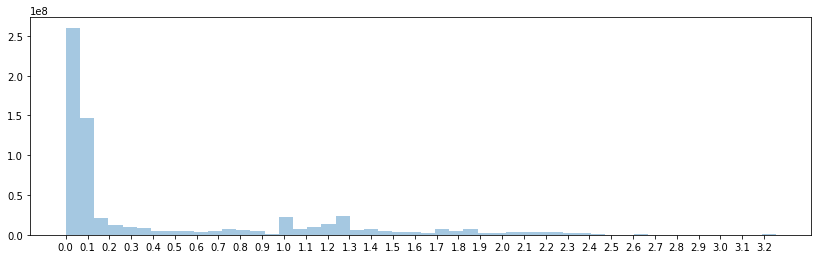

20000/494744


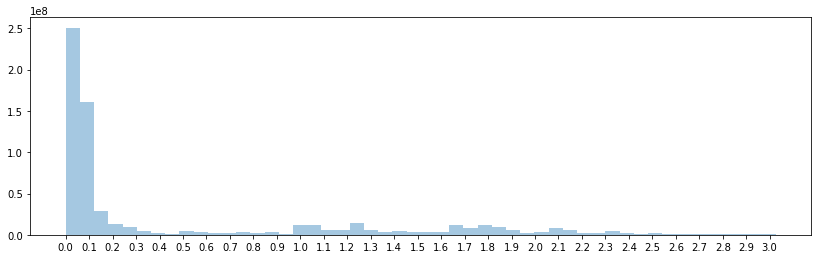

30000/494744


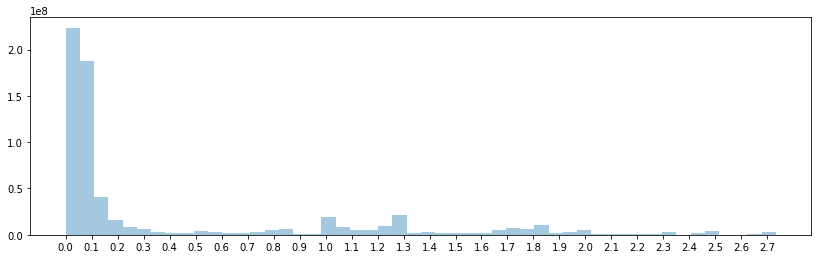

40000/494744


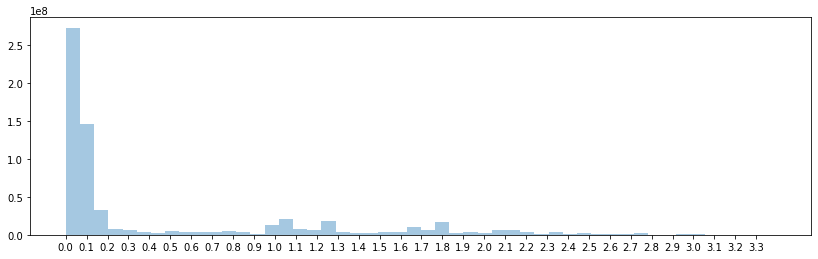

50000/494744


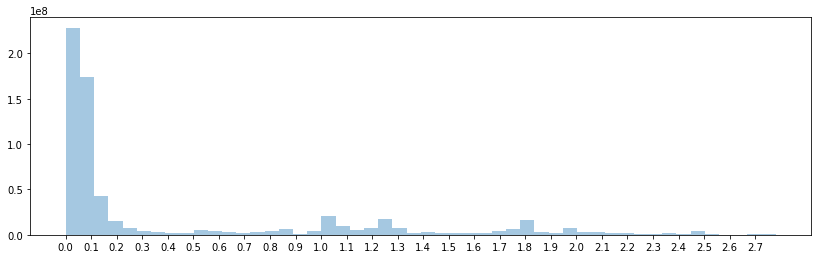

60000/494744


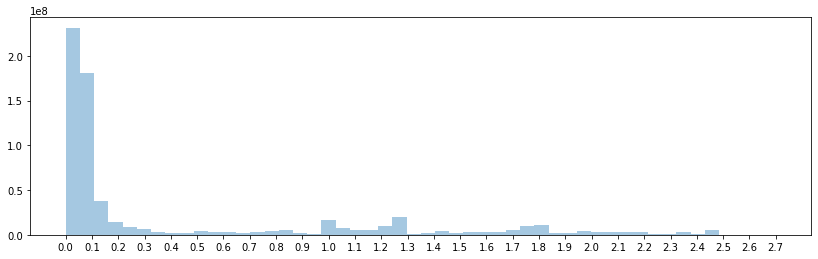

70000/494744


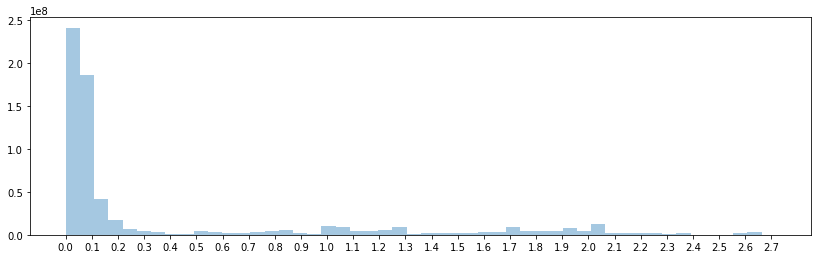

80000/494744


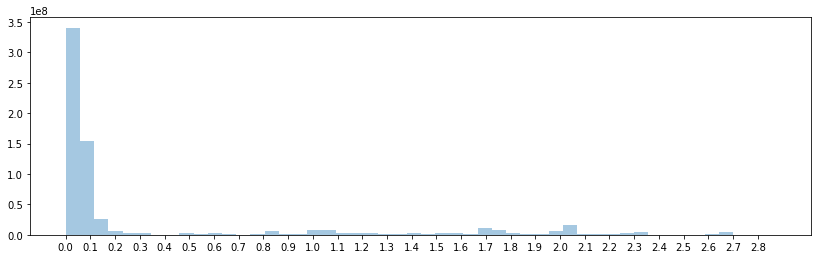

90000/494744


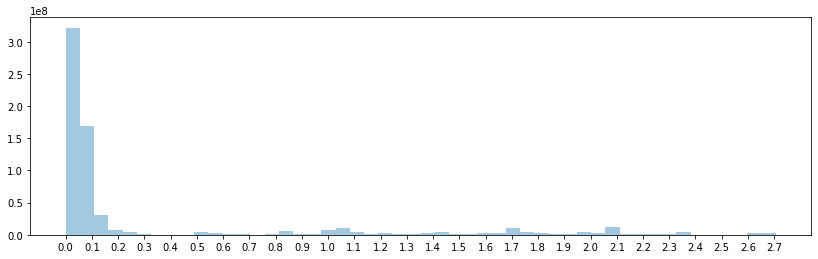

100000/494744


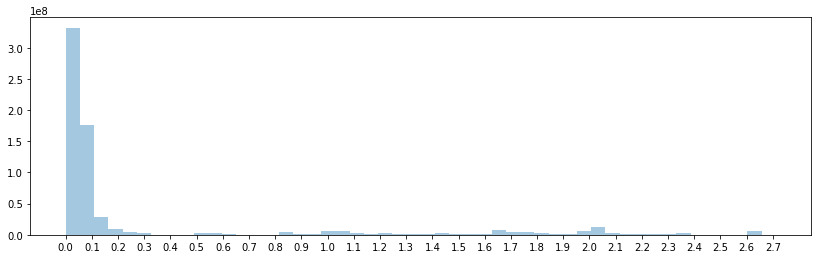

110000/494744


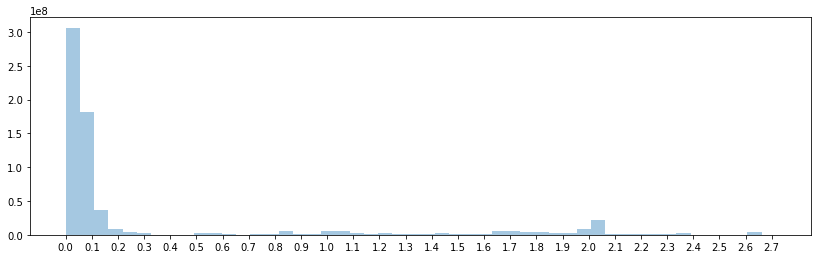

120000/494744


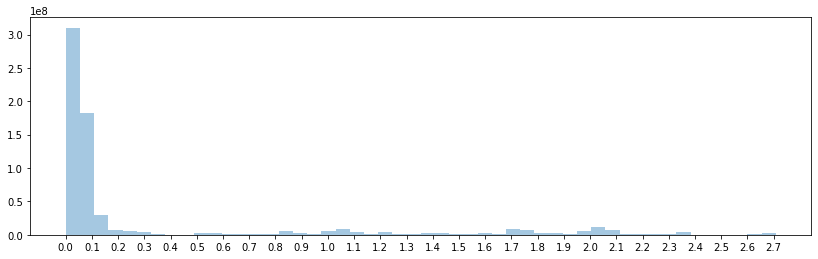

130000/494744


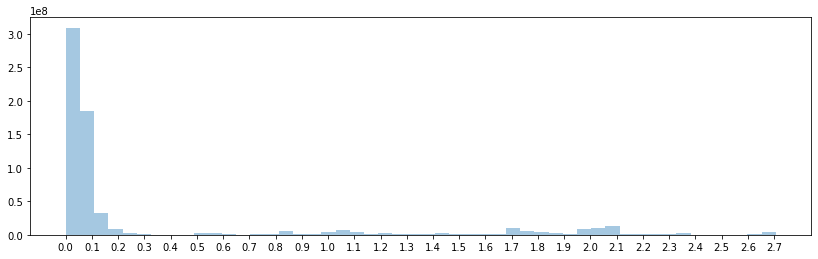

140000/494744


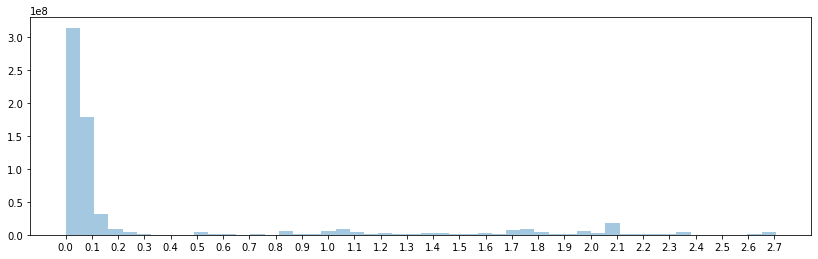

150000/494744


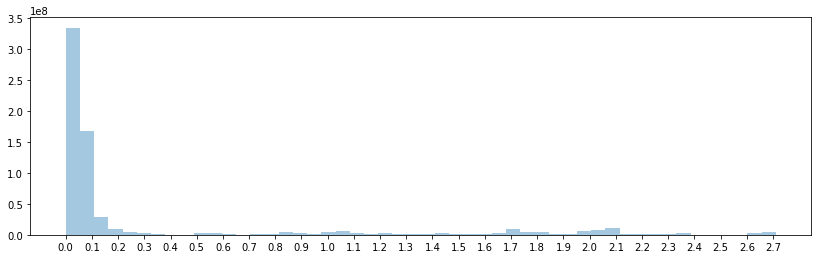

160000/494744


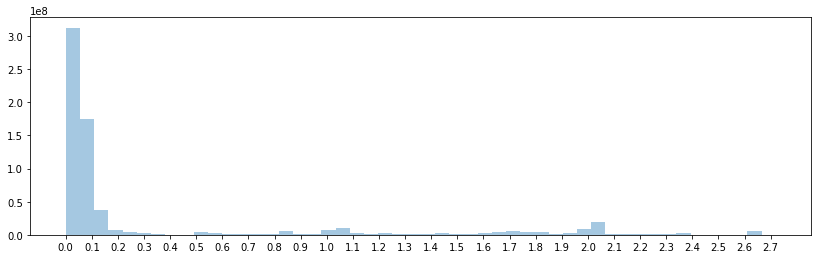

170000/494744


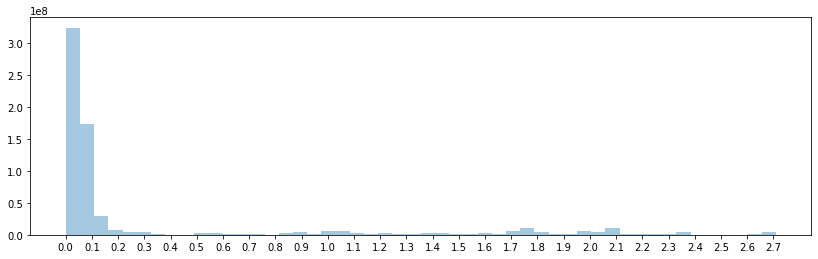

180000/494744


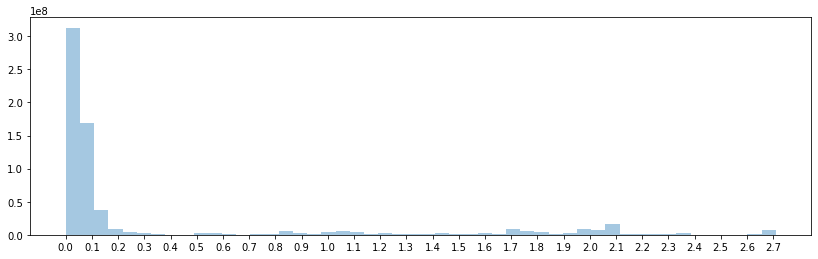

190000/494744


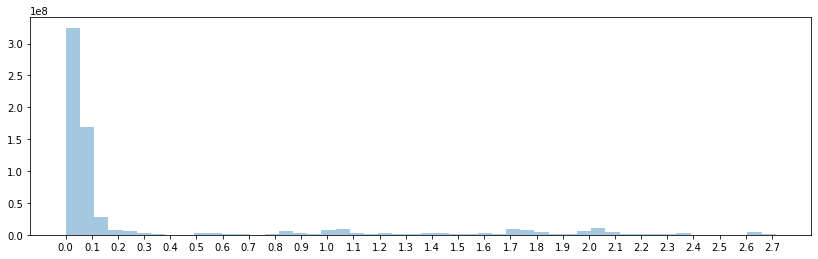

200000/494744


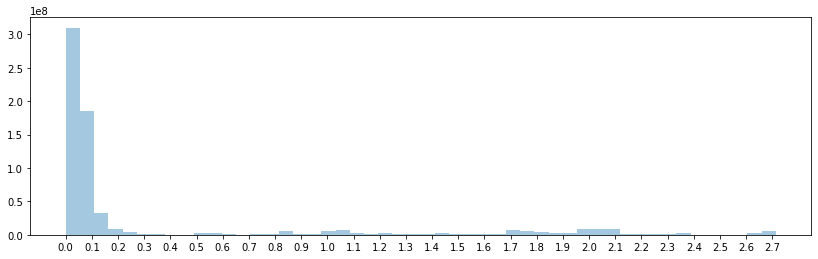

210000/494744


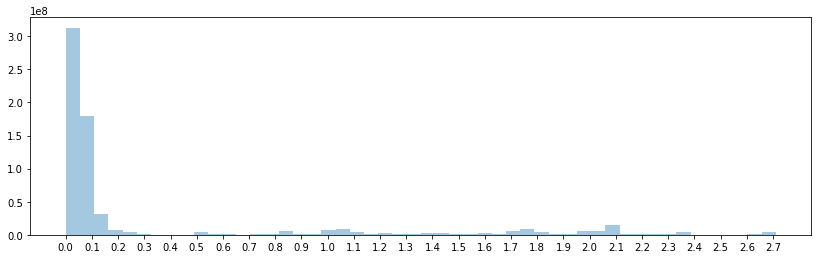

220000/494744


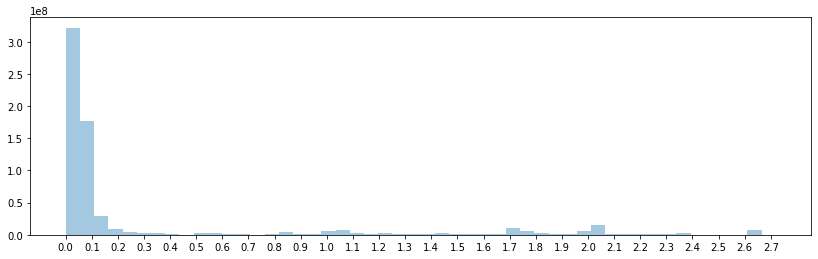

230000/494744


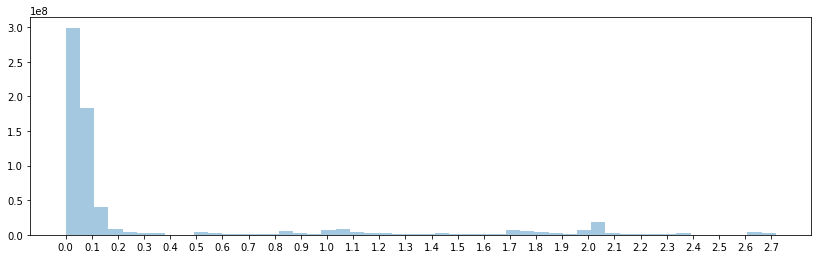

240000/494744


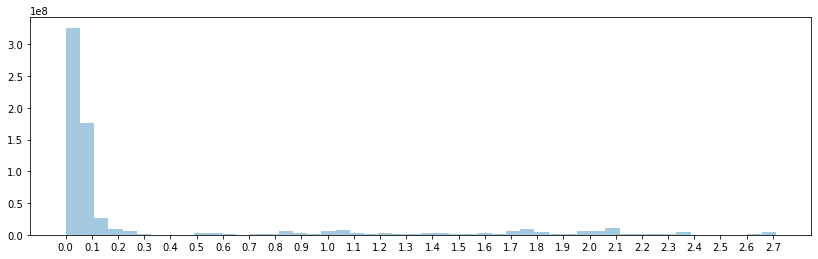

250000/494744


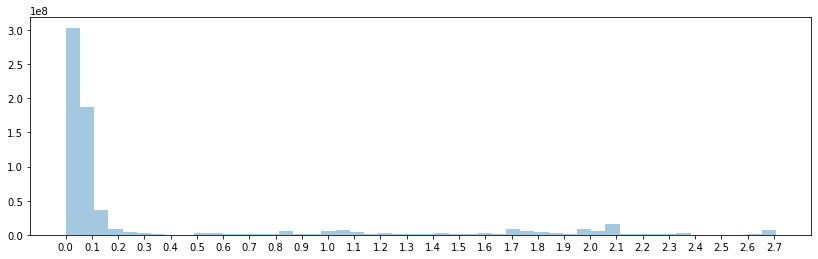

260000/494744


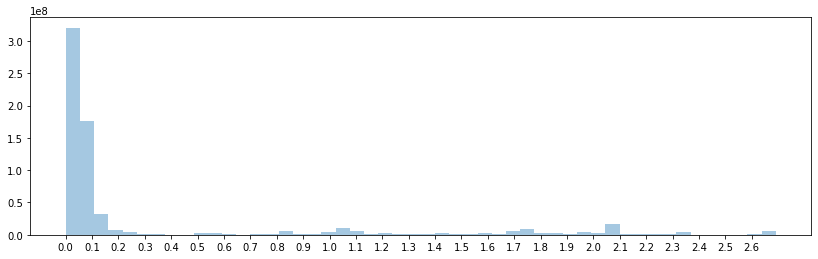

270000/494744


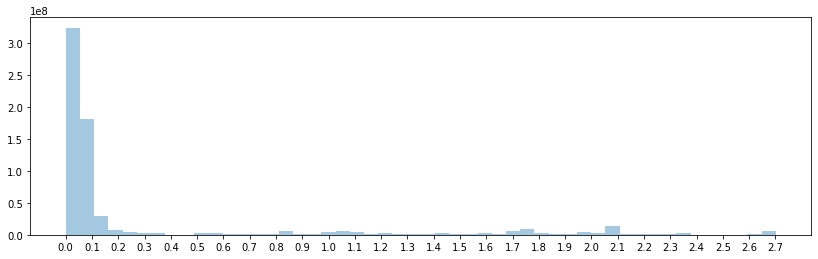

280000/494744


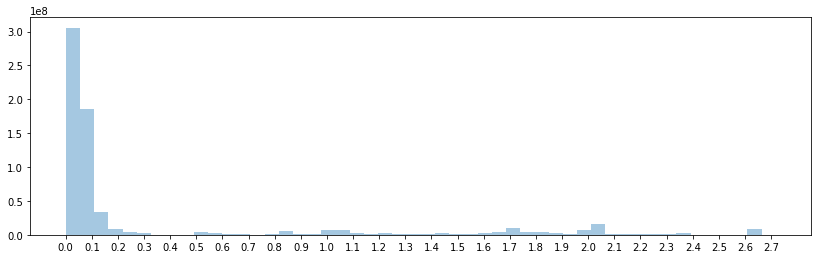

290000/494744


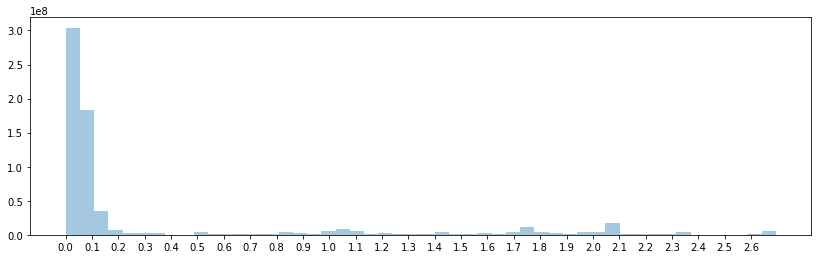

300000/494744


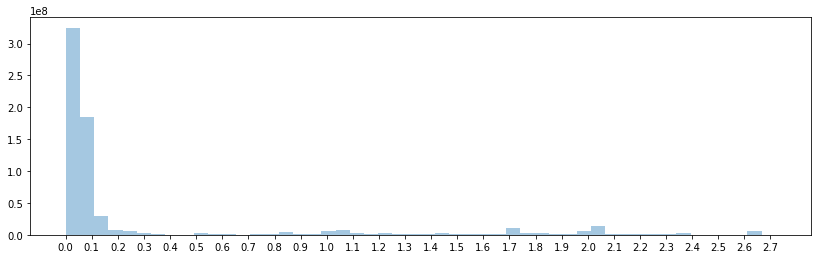

310000/494744


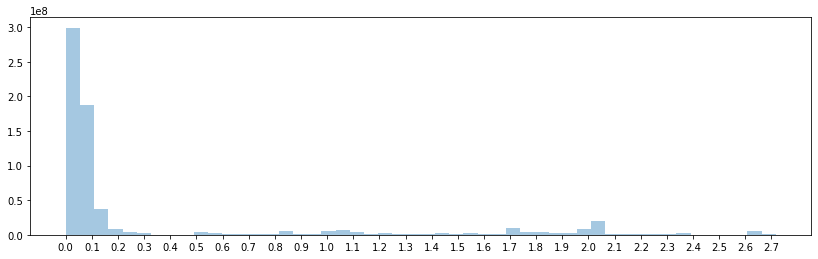

320000/494744


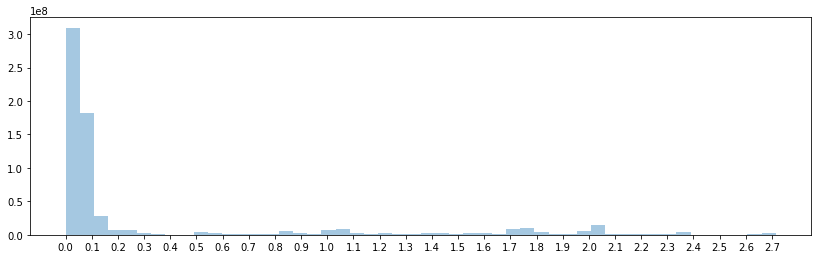

330000/494744


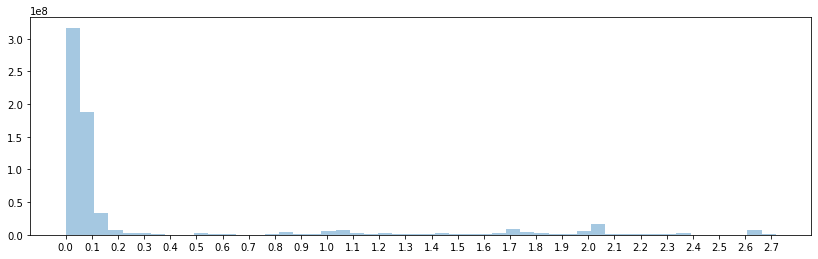

340000/494744


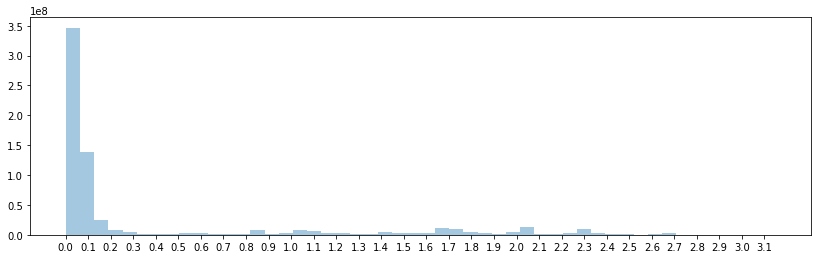

350000/494744


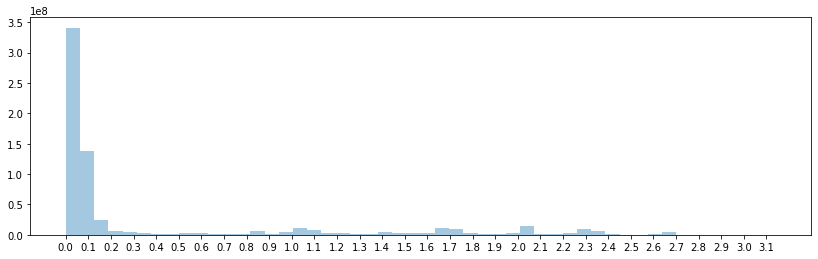

360000/494744


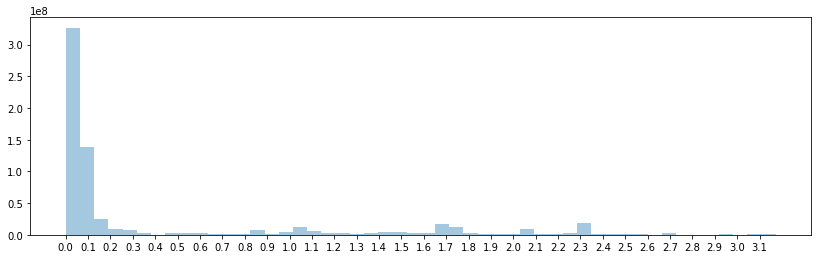

370000/494744


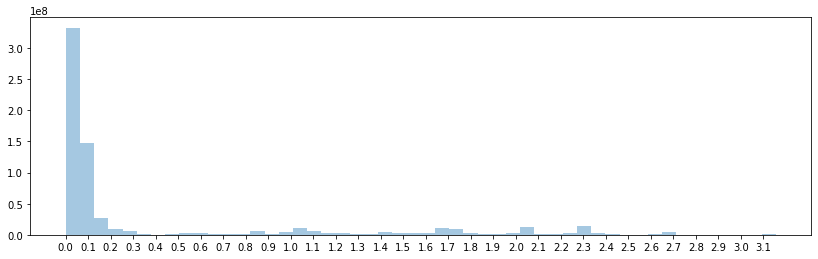

380000/494744


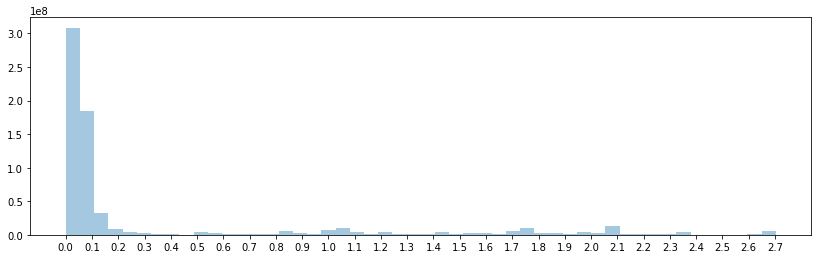

390000/494744


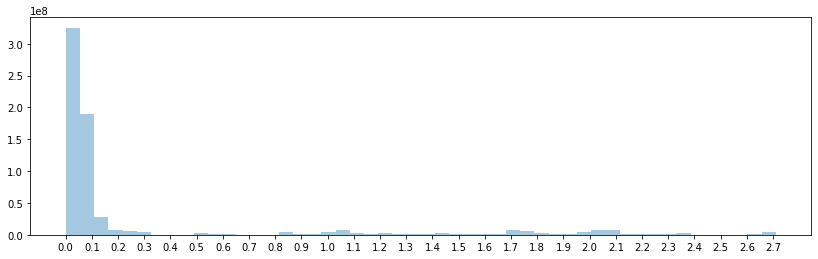

400000/494744


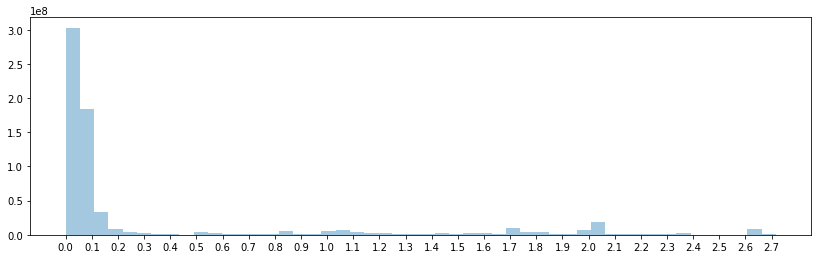

410000/494744


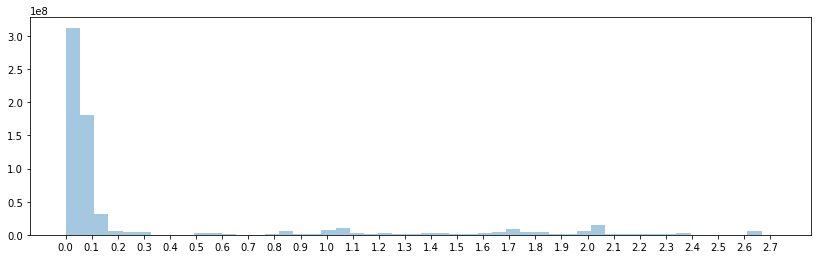

420000/494744


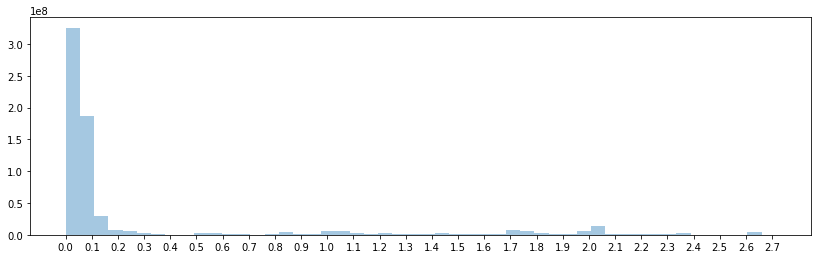

430000/494744


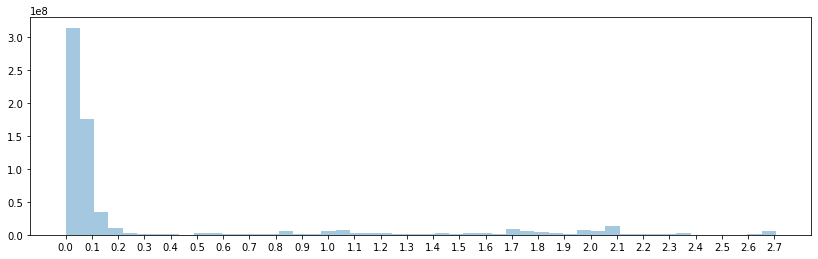

440000/494744


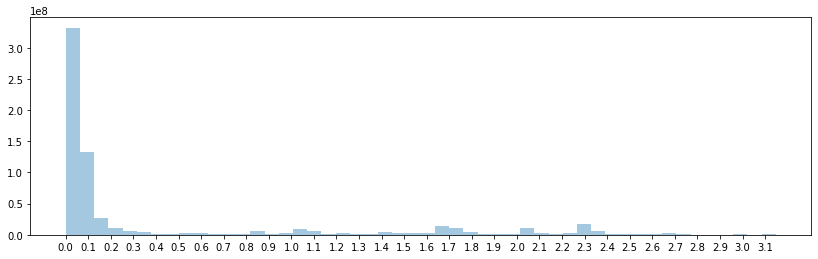

450000/494744


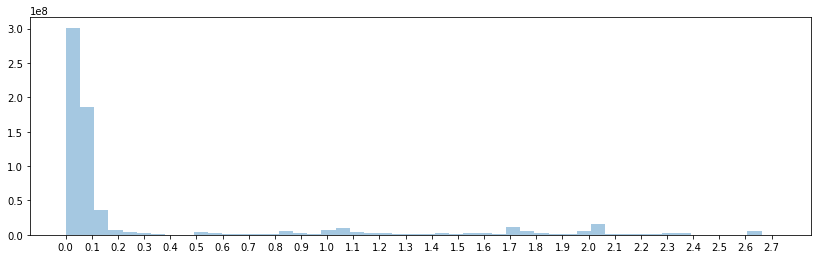

460000/494744


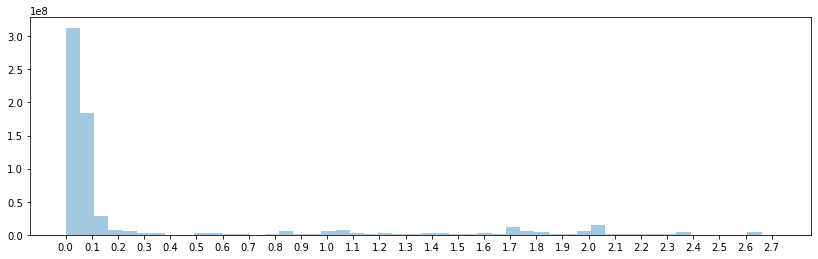

470000/494744


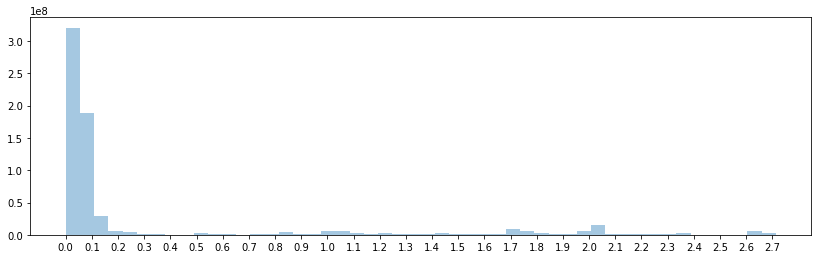

480000/494744


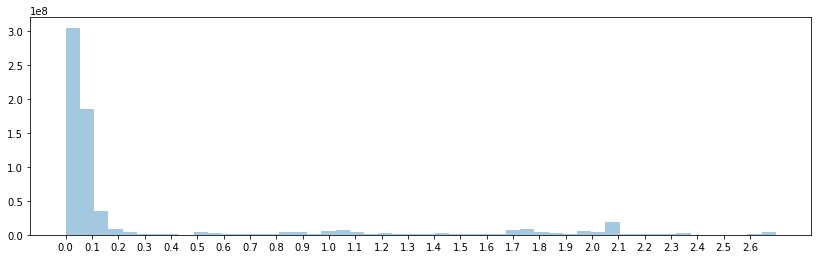

490000/494744


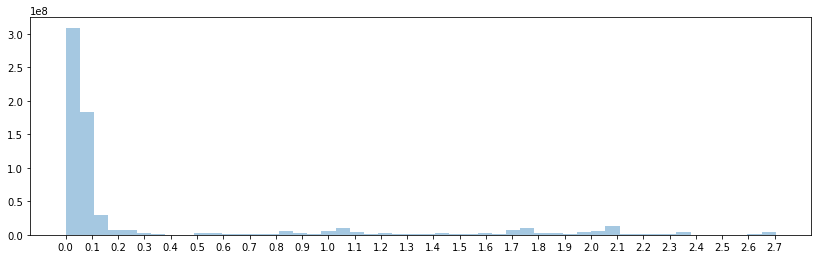

In [ ]:
distances=[]
for j in range(0,windows):
    if(j!=0 and j%10000==0):
        print(str(j)+"/"+str(windows))
        plt.figure(figsize=(14,4))
        sns.distplot(np.array(distances).flatten(),kde=False)
        plt.xticks(np.arange(0,np.max(np.array(distances).flatten()),0.1))
        plt.show()
        distances=[]
    window=log_normalize[j:j+n].values
    distances.append(sklearn.metrics.pairwise.pairwise_distances(window))

Looking at the plots above, it is possible to identify 2 main intervals of interest, and use them to define global parameters to transform each window in a consistent way:

- a first interval between 0 and 0.3, including the noise and the small variations within a window. Here is where I decided to focus with the BLUE channel:

    $B_{interval}=[0,0.3]$
    

- a second interval between 1 and 3.5, including the big variations of the system. Here is where I put the RED channel:

    $R_{interval}=[1,3.5]$
    

Finally, the logarithm is capable of pushing the second interval towards the first one, including also those middle values between 0.3 and 1 that look to appear with less frequency. The GREEN channel is then set as
    
$G_{interval}=[\log(0.1),\log(3.1)]$
    
where 0.1 is just a jitter value not to make things grow up to infinity.

In order to have a further confirmation about these considerations, I have also plotted the same distributions for the attack period:

10000/449663


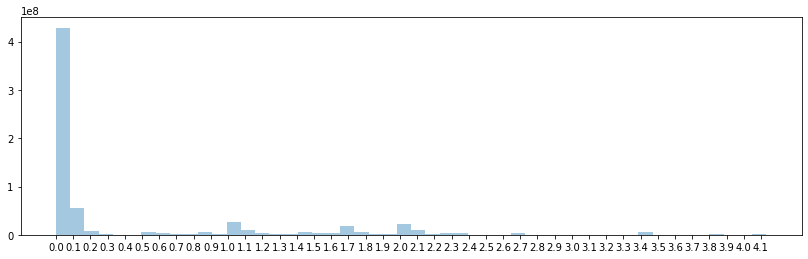

20000/449663


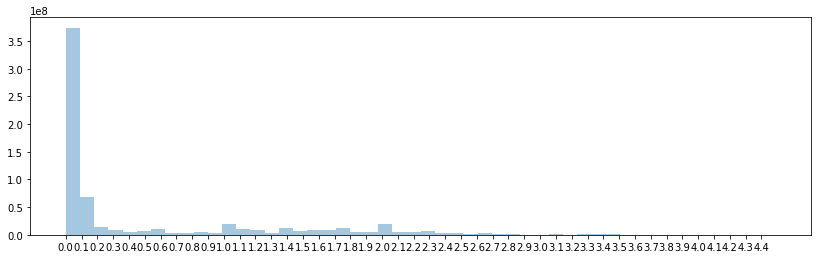

30000/449663


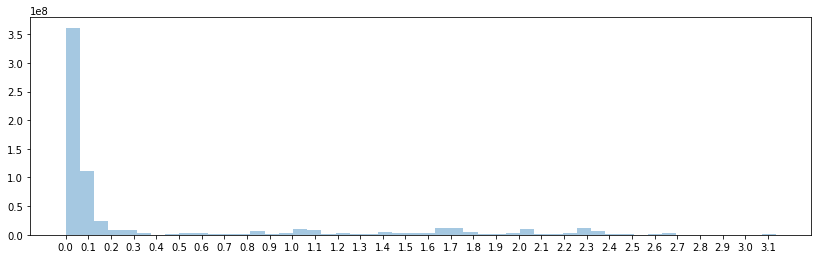

40000/449663


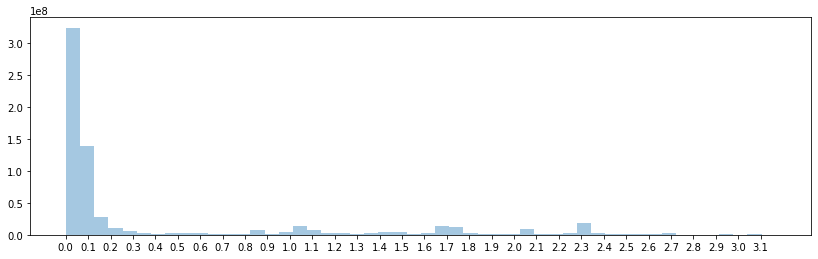

50000/449663


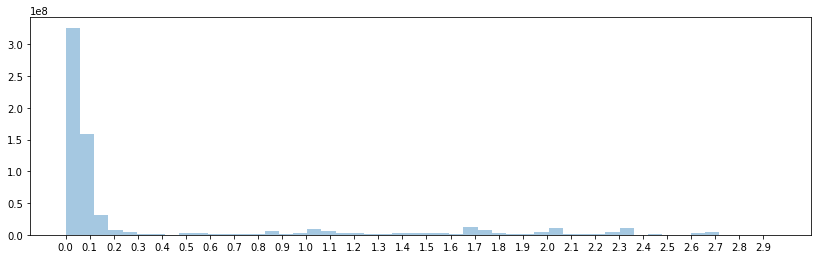

60000/449663


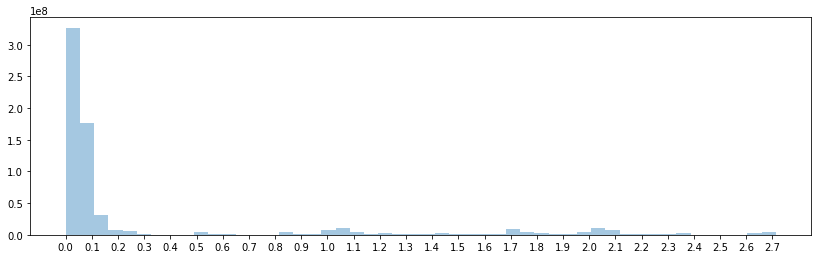

70000/449663


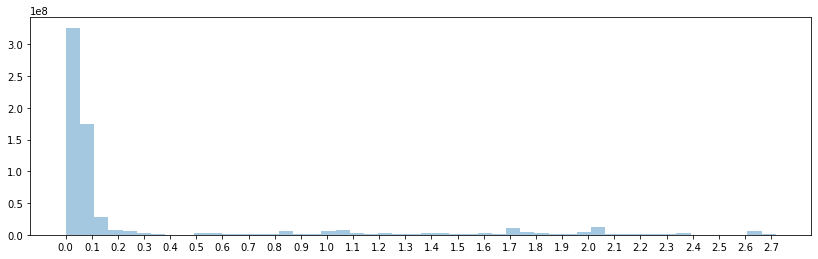

80000/449663


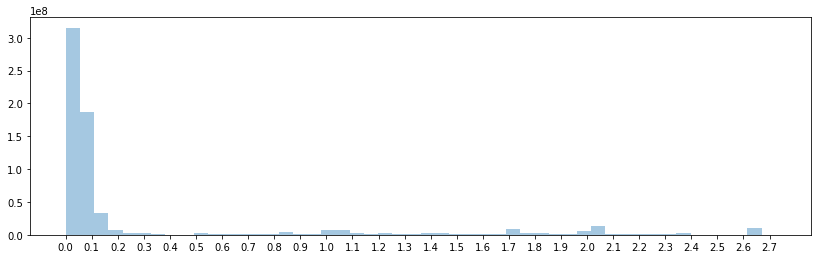

90000/449663


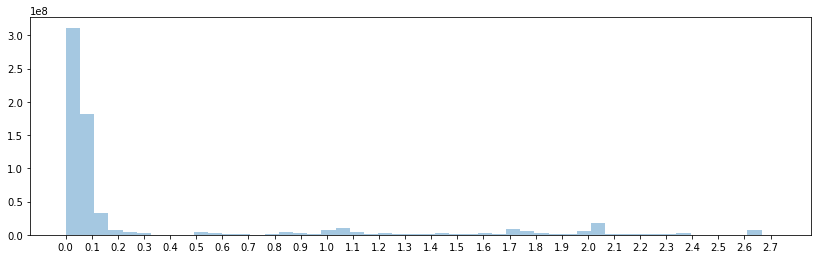

100000/449663


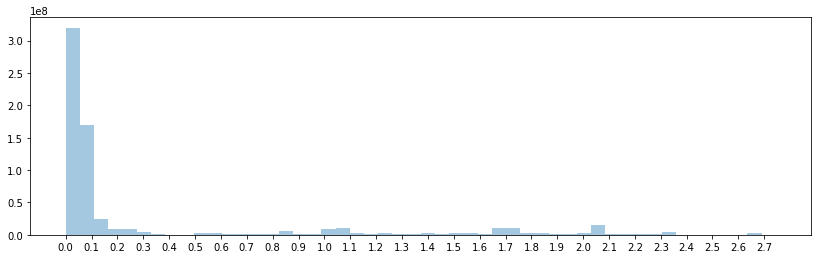

110000/449663


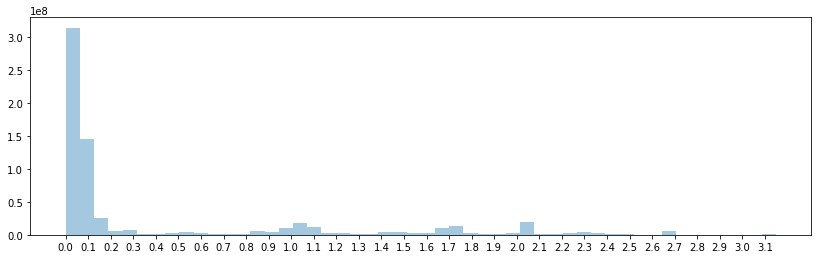

120000/449663


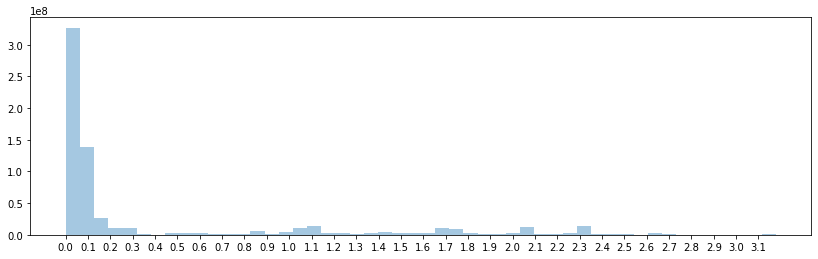

130000/449663


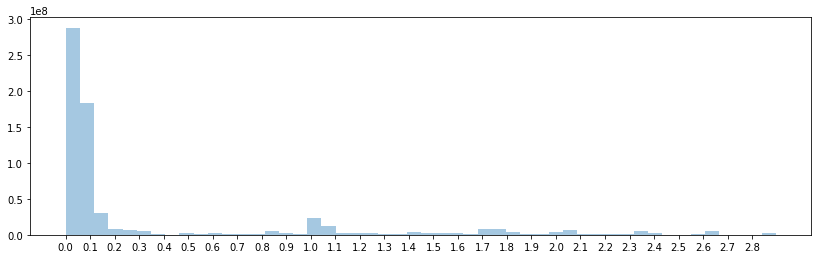

140000/449663


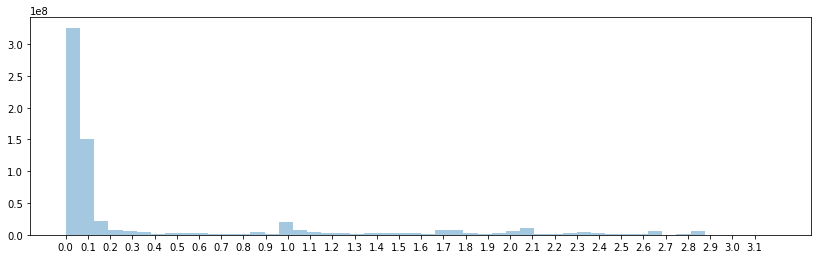

150000/449663


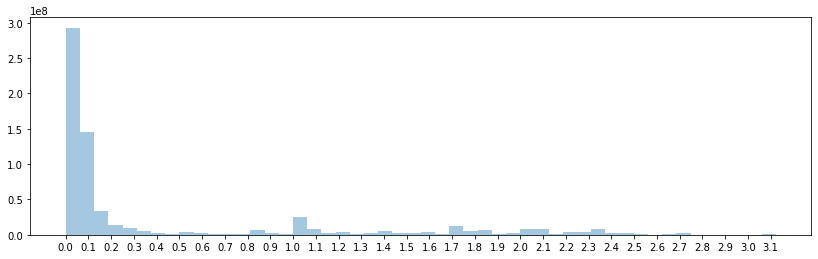

160000/449663


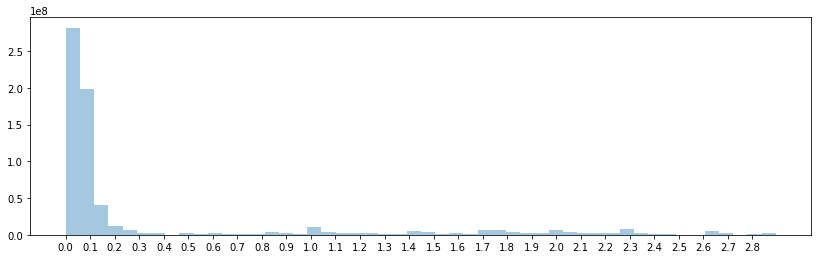

170000/449663


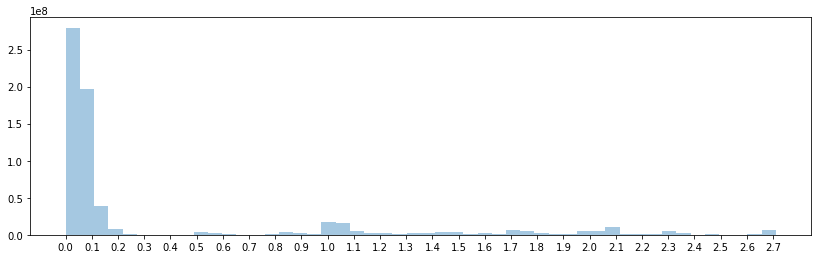

180000/449663


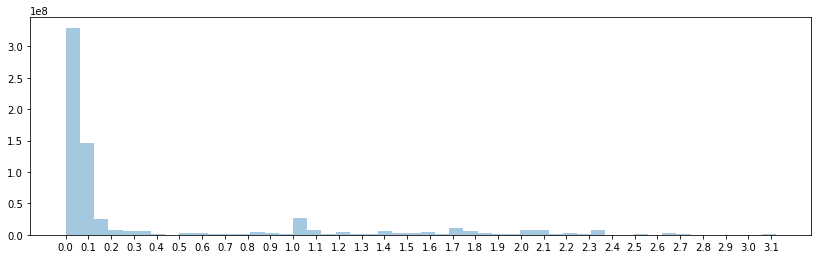

190000/449663


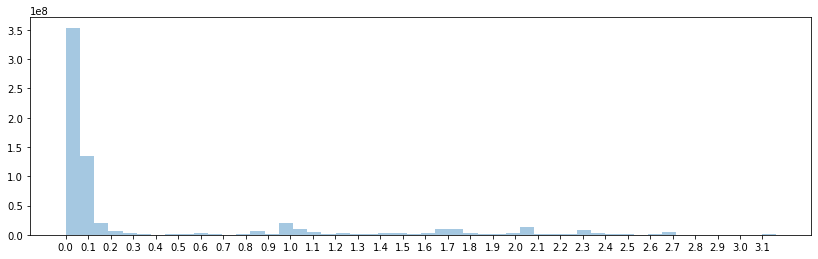

200000/449663


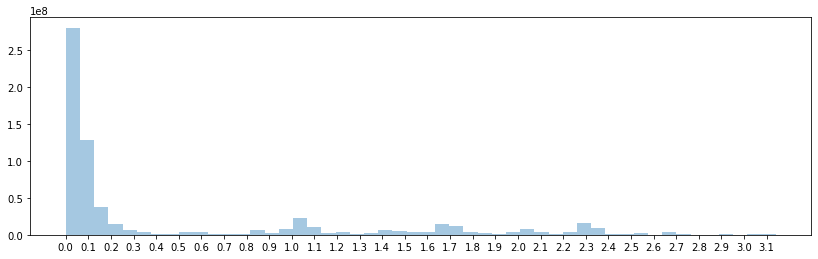

210000/449663


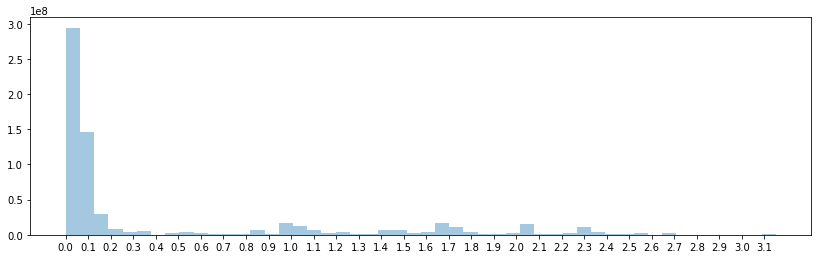

220000/449663


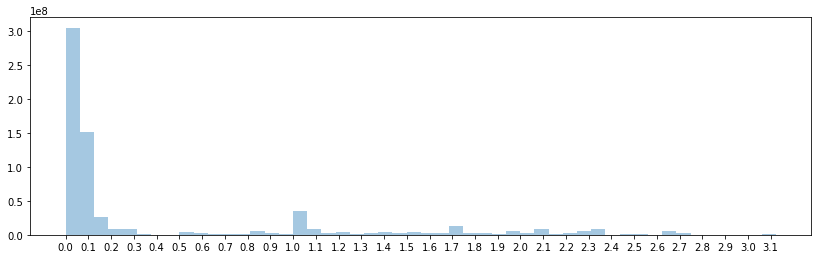

230000/449663


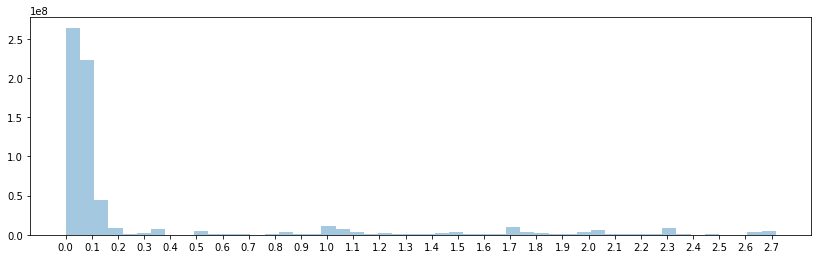

240000/449663


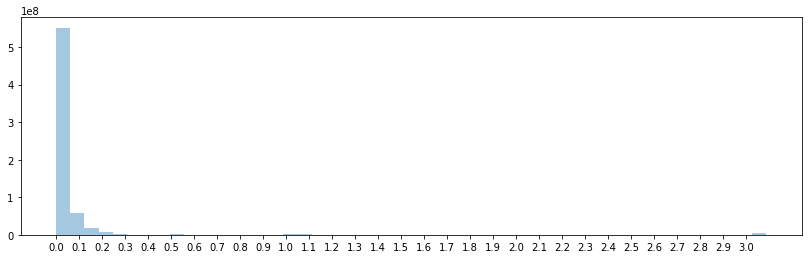

250000/449663


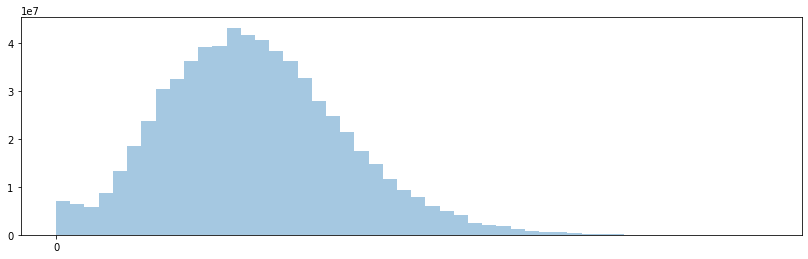

260000/449663


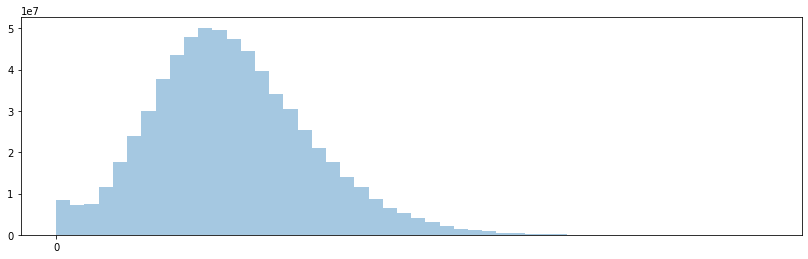

270000/449663


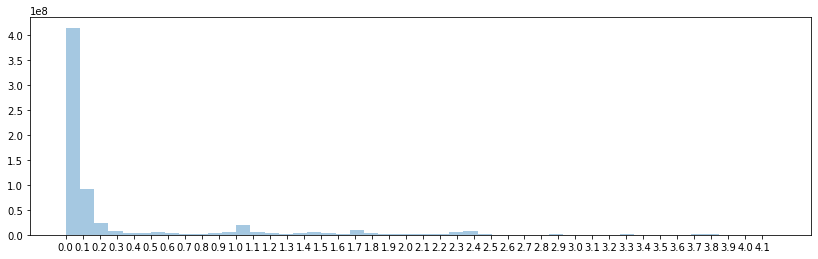

280000/449663


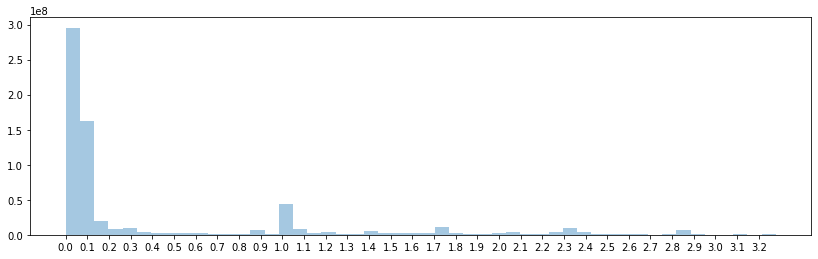

290000/449663


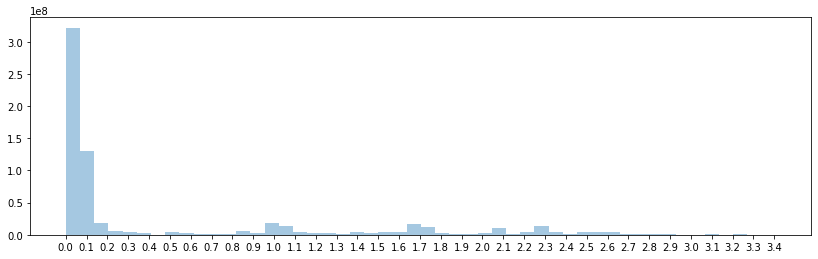

300000/449663


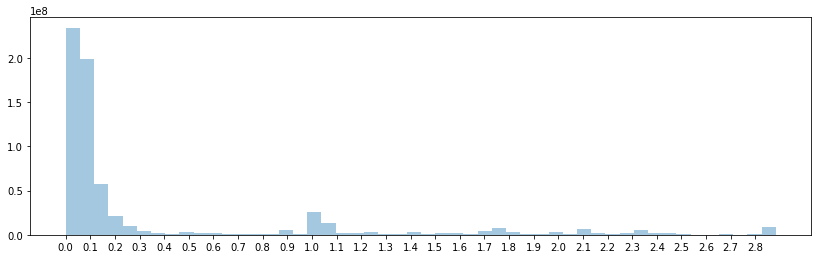

310000/449663


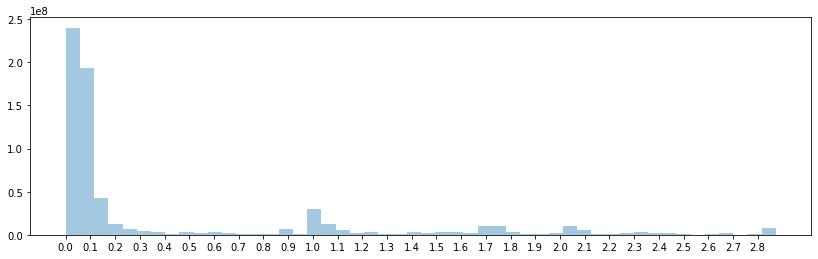

320000/449663


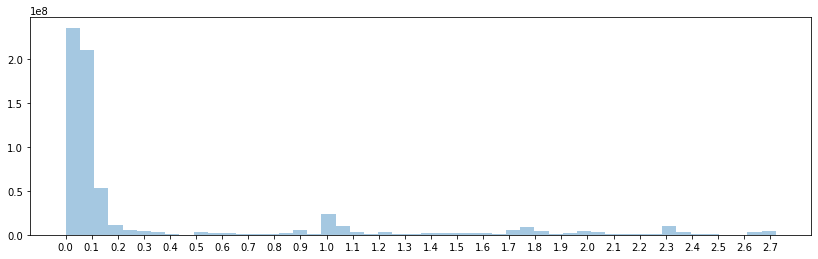

330000/449663


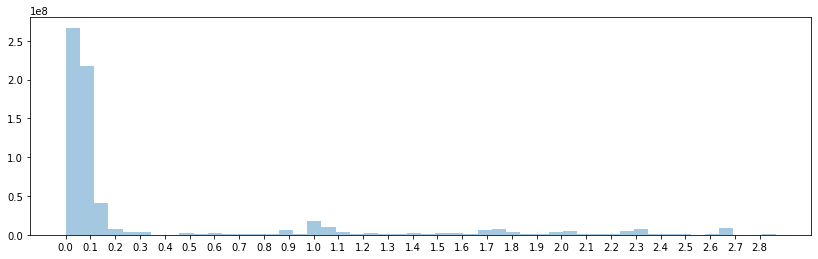

340000/449663


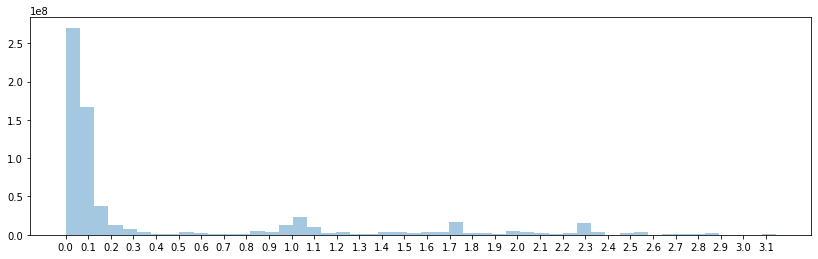

350000/449663


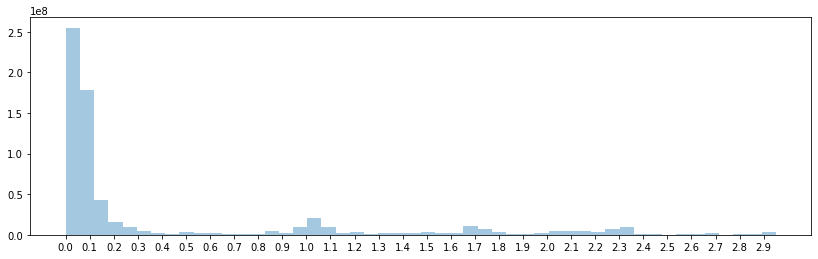

360000/449663


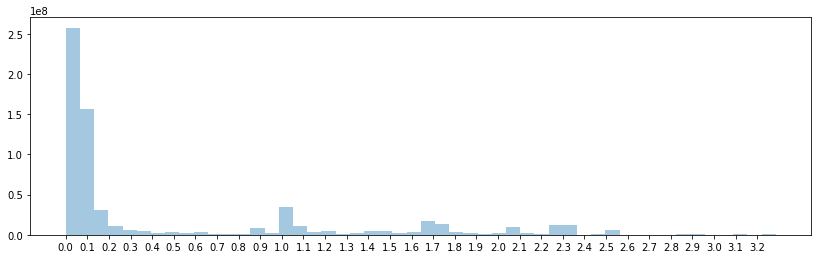

370000/449663


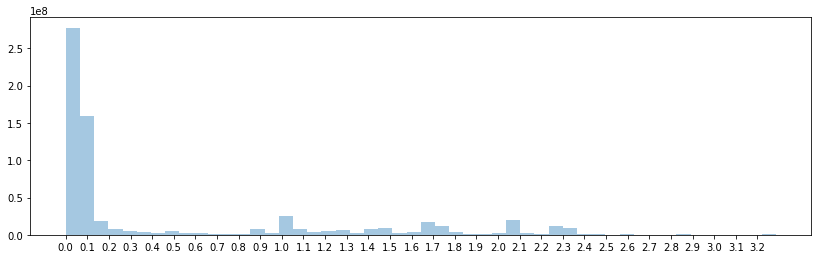

380000/449663


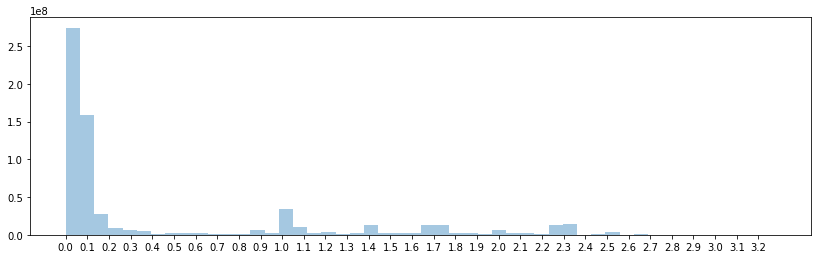

390000/449663


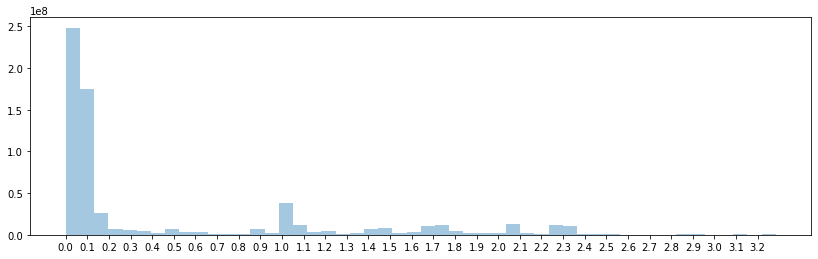

400000/449663


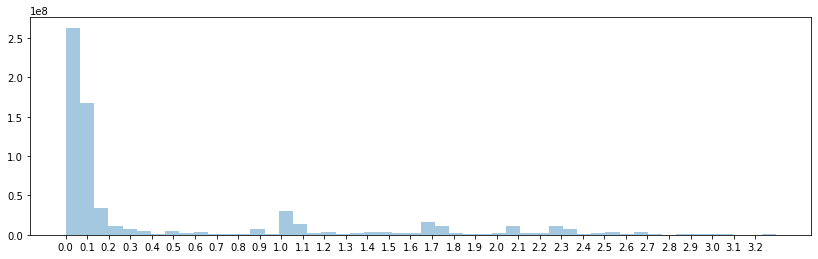

410000/449663


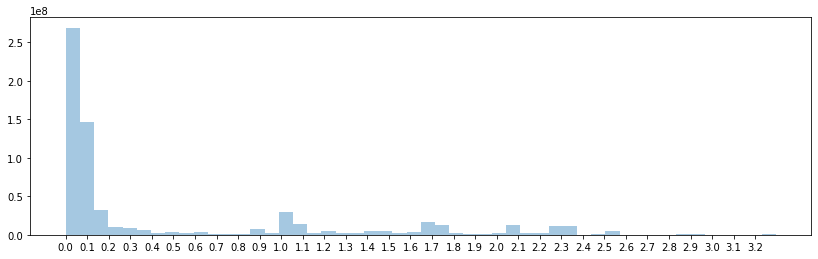

420000/449663


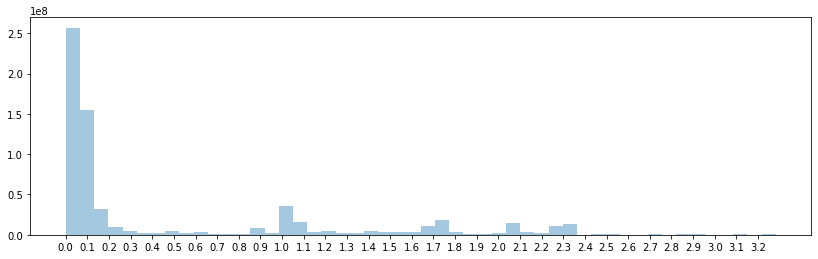

430000/449663


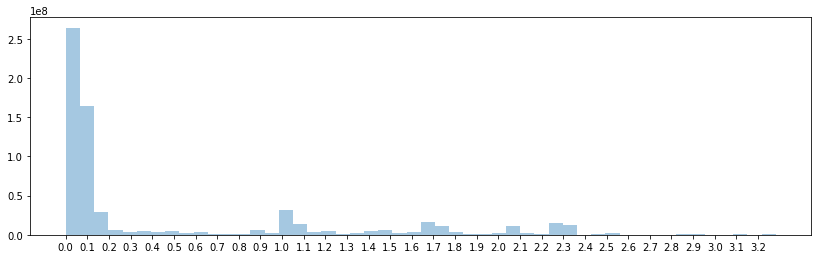

440000/449663


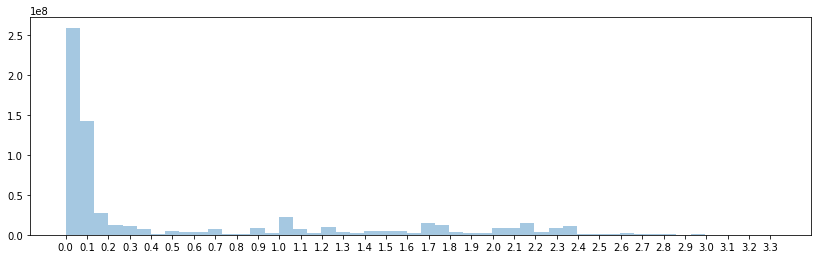

In [ ]:
distances=[]
for j in range(0,windows):

    if(j!=0 and j%10000==0):
        print(str(j)+"/"+str(windows))
        plt.figure(figsize=(14,4))
        sns.distplot(np.array(distances).flatten(),kde=False)
        plt.xticks(np.arange(0,np.max(np.array(distances).flatten()),0.1))
        plt.show()
        distances=[]
    window=log_test_normalize[j:j+n].values
    distances.append(sklearn.metrics.pairwise.pairwise_distances(window))

These plots brought me to two further considerations:

- since, from the first two plots in particular but even later, it looks like the maximum distance within a window increases a lot (from 3.3 to 4.4), I decided to increase the big variations window (RED channel) a bit. (up to 3.7 instead than 3.5)

- a couple of plots show almost no changes for 20k windows (from 250000/449663 to 270000/449663), something that has never happened in a normal period, almost like the system was shut down. This just increases the importance to focus on low distances too, done with the BLUE channel.

This is the old version of the recurrence_plot function.

```python
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sklearn.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    return d
```


And this, instead, is the new one:

In [ ]:
def recurrence_plot(s,R=True,G=True,B=True):

    matr=sklearn.metrics.pairwise.pairwise_distances(s)

    g = np.log(matr+0.1)
    g = (g - np.log(0.1)) / (np.log(3+0.1) - np.log(0.1))
    g = np.where(g>1,1,g)
    if(not G):
        g = np.zeros(g.shape)
    r = np.where(matr<1,1,matr)
    r = (r - 1) / (3.7 - 1)
    r = np.where(r>1,1,r)
    if(not R):
        r=np.zeros(r.shape)
    b = np.where(matr>0.03,0.03,matr)
    b = (b - 0) / (0.03 - 0)
    b = np.where(b>1,1,b)
    if(not B):
        b=np.zeros(b.shape)

    d=np.dstack((r,g,b)) 
    return d

Following, an example:

**<span style="color:red">RED channel</span>**: big variations

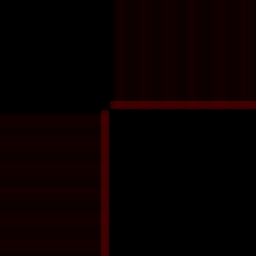

In [ ]:
rgb=cm.ScalarMappable().to_rgba(recurrence_plot(log_normalize[500:500+n].values,R=True,G=False,B=False),bytes=True)[:,:,:3]
Image.fromarray(rgb)

**<span style="color:green">GREEN channel</span>**: logarithm

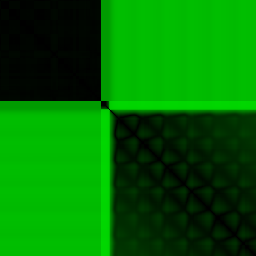

In [ ]:
rgb=cm.ScalarMappable().to_rgba(recurrence_plot(log_normalize[500:500+n].values,R=False,G=True,B=False),bytes=True)[:,:,:3]
Image.fromarray(rgb)

**<span style="color:blue">BLUE channel</span>**: small variations

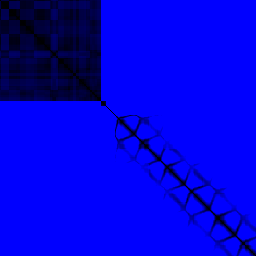

In [ ]:
rgb=cm.ScalarMappable().to_rgba(recurrence_plot(log_normalize[500:500+n].values,R=False,G=False,B=True),bytes=True)[:,:,:3]
Image.fromarray(rgb)

Finally all together:

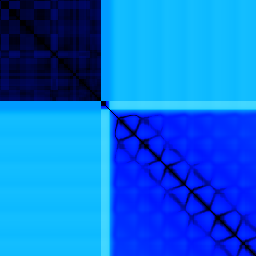

In [ ]:
rgb=cm.ScalarMappable().to_rgba(recurrence_plot(log_normalize[500:500+n].values),bytes=True)[:,:,:3]
Image.fromarray(rgb)

### Export .tfr

In [ ]:
%cd /content/usad

import time
from dataset_tool import TFRecordExporter
windows=log_test_normalize.shape[0]-n

for i in range(0,10):
    destination="/content/drive/My Drive/GAN/Week12/records_"+format(i,'02d')
    with TFRecordExporter(destination, windows) as tfr:
        for j in range(i*50000,(i+1)*50000):
            if(j%1000==0):
                print(str(j)+"/"+str(windows))
                time.sleep(60)
            if(j>=windows):
                break
            window=log_test_normalize[j:j+n].values
            rgb=cm.ScalarMappable().to_rgba(recurrence_plot(window),bytes=True)[:,:,:3]

            img = np.asarray(Image.fromarray(rgb))

            resolution = img.shape[0]
            channels = img.shape[2] if img.ndim == 3 else 1
            if img.shape[1] != resolution:
                error('Input images must have the same width and height')
            if resolution != 2 ** int(np.floor(np.log2(resolution))):
                error('Input image resolution must be a power-of-two')
            if channels not in [1, 3]:
                error('Input images must be stored as RGB or grayscale')

            if channels == 1:
                img = img[np.newaxis, :, :] # HW => CHW
            else:
                img = img.transpose([2, 0, 1]) # HWC => CHW
            tfr.add_image(img)
    time.sleep(60)

/content/usad
Creating dataset "/content/drive/My Drive/GAN/Week12/records_00"
0/449663
1000/449663
2000/449663
3000/449663
4000/449663
5000/449663
6000/449663
7000/449663
8000/449663
9000/449663
10000/449663
11000/449663
12000/449663
13000/449663
14000/449663
15000/449663
16000/449663
17000/449663
18000/449663
19000/449663
20000/449663
21000/449663
22000/449663
23000/449663
24000/449663
25000/449663
26000/449663
27000/449663
28000/449663
29000/449663
30000/449663
31000/449663
32000/449663
33000/449663
34000/449663
35000/449663
36000/449663
37000/449663
38000/449663
39000/449663
40000/449663
41000/449663
42000/449663
43000/449663
44000/449663
45000/449663
46000/449663
47000/449663
48000/449663
49000/449663
Added 50000 images.
Creating dataset "/content/drive/My Drive/GAN/Week12/records_01"
50000/449663
51000/449663
52000/449663
53000/449663
54000/449663
55000/449663
56000/449663
57000/449663
58000/449663
59000/449663
60000/449663
61000/449663
62000/449663
63000/449663
64000/449663
6500

KeyboardInterrupt: ignored

## Training

In [ ]:
%cd /content/usad
!nvcc test_nvcc.cu -o test_nvcc -run

/content/usad
CPU says hello.
GPU says hello.


In [ ]:
!mkdir -p /content/usad/datasets/
!mkdir -p /content/usad/backups/
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/records_01" "/content/usad/datasets/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_00/00001-stylegan2-records_00-1gpu-config-f/network-snapshot-000080.pkl" "/content/usad/backups/"

'/content/drive/My Drive/GAN/Week11/records_01' -> '/content/usad/datasets/records_01'
'/content/drive/My Drive/GAN/Week11/records_01/records_01-r08.tfrecords' -> '/content/usad/datasets/records_01/records_01-r08.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_01/records_01-r07.tfrecords' -> '/content/usad/datasets/records_01/records_01-r07.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_01/records_01-r06.tfrecords' -> '/content/usad/datasets/records_01/records_01-r06.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_01/records_01-r05.tfrecords' -> '/content/usad/datasets/records_01/records_01-r05.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_01/records_01-r04.tfrecords' -> '/content/usad/datasets/records_01/records_01-r04.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_01/records_01-r03.tfrecords' -> '/content/usad/datasets/records_01/records_01-r03.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_01/records_01-r02.tfrecords' -> '/content/usad/

In [ ]:
!python run_training.py --data-dir=datasets --dataset=records_01 --result-dir="/content/drive/My Drive/GAN/Week11/results_01" --config=config-f

Local submit - run_dir: /content/drive/My Drive/GAN/Week11/results_01/00001-stylegan2-records_01-1gpu-config-f
dnnlib: Running training.training_loop.training_loop() on localhost...
Streaming data using training.dataset.TFRecordDataset...
tcmalloc: large alloc 4294967296 bytes == 0x78fa000 @  0x7faeb2177001 0x7faeaebc3765 0x7faeaec27bb0 0x7faeaec29a4f 0x7faeaecc0048 0x50a635 0x50cd96 0x507d64 0x509042 0x594931 0x549e5f 0x5513d1 0x59fc4e 0x50d356 0x507d64 0x588e5c 0x59fc4e 0x50d356 0x507d64 0x588e5c 0x59fc4e 0x50d356 0x509758 0x50a48d 0x50bfb4 0x509758 0x50a48d 0x50bfb4 0x507d64 0x588e5c 0x59fc4e
tcmalloc: large alloc 4294967296 bytes == 0x7face9424000 @  0x7faeb21751e7 0x7faeaebc35e1 0x7faeaec27c78 0x7faeaec27f37 0x7faeaecbff28 0x50a635 0x50cd96 0x507d64 0x509a90 0x50a48d 0x50cd96 0x507d64 0x509a90 0x50a48d 0x50cd96 0x507d64 0x509a90 0x50a48d 0x50cd96 0x509758 0x50a48d 0x50bfb4 0x507d64 0x509a90 0x50a48d 0x50bfb4 0x507d64 0x509a90 0x50a48d 0x50cd96 0x507d64
tcmalloc: large alloc 429496

## Testing w/ Projection

### SWaT

In [ ]:
%cd /content/usad
!nvcc test_nvcc.cu -o test_nvcc -run

/content/usad
CPU says hello.
GPU says hello.


In [ ]:
attack="/content/drive/My\ Drive/GAN/Week12/records_00/*"
normal="/content/drive/My\ Drive/GAN/Week11/records_09/*"

!mkdir -p /content/usad/datasets/normal/
!mkdir -p /content/usad/backups/
!cp --verbose -rf $normal "/content/usad/datasets/normal/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_01/00001-stylegan2-records_01-1gpu-config-f/network-snapshot-000145.pkl" "/content/usad/backups/"

'/content/drive/My Drive/GAN/Week11/results_01/00001-stylegan2-records_01-1gpu-config-f/network-snapshot-000145.pkl' -> '/content/usad/backups/network-snapshot-000145.pkl'
cp: error reading '/content/drive/My Drive/GAN/Week11/results_01/00001-stylegan2-records_01-1gpu-config-f/network-snapshot-000145.pkl': Input/output error


In [ ]:
import training.dataset
import projector
import run_projector
import pretrained_networks
import dnnlib

data_dir="/content/usad/datasets"
dataset_name="normal"
network_pkl="/content/usad/backups/network-snapshot-000145.pkl"
num_images=10

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
proj = projector.Projector(verbose=True,num_steps=1000,info_freq=10)
proj.set_network(Gs,perfect=False,D=_D,quadratic_evaluation=True)

print('Loading images from "%s"...' % dataset_name)
dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, repeat=False)#, shuffle_mb=0)
assert dataset_obj.shape == Gs.output_shape[1:]

for image_idx in range(num_images):
  print('Projecting image %d/%d ...' % (image_idx, num_images))
  images, _labels = dataset_obj.get_minibatch_np(1)
  """if image_idx<=12:
    continue"""

  output_name=format(image_idx,'04d')
  with open(output_name + '.txt','w') as output:
    images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    proj.set_info_output(output)
    run_projector.project_image(proj, targets=images, png_prefix=dnnlib.make_run_dir_path(output_name+'-'), num_snapshots=1)

  destination='/content/drive/My\ Drive/GAN/Week14/provona/img/'
  !mv {output_name+'-*.png'} $destination
  print("Images stored successfully")

  destination='/content/drive/My\ Drive/GAN/Week14/provona/text/'
  !mv {output_name + '.txt'} $destination
  print((output_name + '.txt')+" stored successfully")


Loading networks from "/content/usad/backups/network-snapshot-000145.pkl"...
Projector: Finding W midpoint and stddev using 10000 samples...
Projector: std = 11.9286
Projector: Setting up noise inputs...
Projector: G_synthesis/noise0 <tf.Variable 'G_synthesis_4/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>
Projector: G_synthesis/noise1 <tf.Variable 'G_synthesis_4/noise1:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise2 <tf.Variable 'G_synthesis_4/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise3 <tf.Variable 'G_synthesis_4/noise3:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise4 <tf.Variable 'G_synthesis_4/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise5 <tf.Variable 'G_synthesis_4/noise5:0' shape=(1, 1, 32, 32) dtype=float32_ref>
Projector: G_synthesis/noise6 <tf.Variable 'G_synthesis_4/noise6:0' shape=(1, 1, 32, 32) dtype=float32_ref>
Projector: G_synthesis/noise7 <tf.Variable 'G_

### FFHQ

In [ ]:
%cd /content/usad
!nvcc test_nvcc.cu -o test_nvcc -run

/content/usad
CPU says hello.
GPU says hello.


In [ ]:
!mkdir -p /content/usad/images/normal/
!mkdir -p /content/usad/images/human/
!mkdir -p /content/usad/images/horse/
!mkdir -p /content/usad/backups/

!unzip -q "/content/drive/My Drive/GAN/detection/images.zip" -d "/content/usad/images/normal/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week14/FFHQ/human.png" "/content/usad/images/human/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week14/FFHQ/horse.png" "/content/usad/images/horse/"

!wget http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl -O "/content/usad/backups/stylegan2-ffhq-config-f.pkl"

'/content/drive/My Drive/GAN/Week14/FFHQ/human.png' -> '/content/usad/images/human/human.png'
'/content/drive/My Drive/GAN/Week14/FFHQ/horse.png' -> '/content/usad/images/horse/horse.png'
--2020-06-19 14:15:47--  http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)... 13.226.50.47, 13.226.50.148, 13.226.50.49, ...
Connecting to d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)|13.226.50.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘/content/usad/backups/stylegan2-ffhq-config-f.pkl’

/content/usad/backu 100%[===================>] 363.99M  68.8MB/s    in 5.5s    

2020-06-19 14:15:53 (65.6 MB/s) - ‘/content/usad/backups/stylegan2-ffhq-config-f.pkl’ saved [381673535/381673535]



In [ ]:
# Convert uploaded images to TFRecords
import dataset_tool

dataset_tool.create_from_images("/content/usad/datasets/normal/", "/content/usad/images/normal/", True)
dataset_tool.create_from_images("/content/usad/datasets/human/", "/content/usad/images/human/", True)
dataset_tool.create_from_images("/content/usad/datasets/horse/", "/content/usad/images/horse/", True)

Loading images from "/content/usad/images/normal/"
Creating dataset "/content/usad/datasets/normal/"
Added 201 images.
Loading images from "/content/usad/images/human/"
Creating dataset "/content/usad/datasets/human/"
Added 1 images.
Loading images from "/content/usad/images/horse/"
Creating dataset "/content/usad/datasets/horse/"
Added 1 images.


In [ ]:
import training.dataset
import projector
import run_projector
import pretrained_networks
import dnnlib

data_dir="/content/usad/datasets"
dataset_name="normal"
network_pkl="/content/usad/backups/stylegan2-ffhq-config-f.pkl"
num_images=100

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
proj = projector.Projector(verbose=True,num_steps=100,info_freq=10)
proj.set_network(Gs,perfect=False,D=_D,quadratic_evaluation=True)

print('Loading images from "%s"...' % dataset_name)
dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, repeat=False)#, shuffle_mb=0)
assert dataset_obj.shape == Gs.output_shape[1:]

for image_idx in range(num_images):
  print('Projecting image %d/%d ...' % (image_idx, num_images))
  images, _labels = dataset_obj.get_minibatch_np(1)
  """if image_idx<=91:
    continue"""

  output_name=format(image_idx,'04d')
  with open(output_name + '.txt','w') as output:
    images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    proj.set_info_output(output)
    run_projector.project_image(proj, targets=images, png_prefix=dnnlib.make_run_dir_path(output_name+'-'), num_snapshots=1)

  destination='/content/drive/My\ Drive/GAN/Week14/normal/img/'
  !mv {output_name+'-*.png'} $destination
  print("Images stored successfully")

  destination='/content/drive/My\ Drive/GAN/Week14/normal/text/'
  !mv {output_name + '.txt'} $destination
  print((output_name + '.txt')+" stored successfully")


Loading networks from "/content/usad/backups/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Projector: Finding W midpoint and stddev using 10000 samples...
Projector: std = 10.0057
Projector: Setting up noise inputs...
Projector: G_synthesis/noise0 <tf.Variable 'G_synthesis_2/noise0:0' shape=(1, 1, 4, 4) dtype=float32_ref>
Projector: G_synthesis/noise1 <tf.Variable 'G_synthesis_2/noise1:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise2 <tf.Variable 'G_synthesis_2/noise2:0' shape=(1, 1, 8, 8) dtype=float32_ref>
Projector: G_synthesis/noise3 <tf.Variable 'G_synthesis_2/noise3:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise4 <tf.Variable 'G_synthesis_2/noise4:0' shape=(1, 1, 16, 16) dtype=float32_ref>
Projector: G_synthesis/noise5 <tf.Variable 'G_synthesis_2/noise5:0' shape=(1, 1, 32, 32) dtype=flo

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
img0,img1=np.load("/content/imgs.npz")['arr_0']

In [ ]:
img0.shape

(4, 3, 256, 256)

In [ ]:
img1.shape

(4, 3, 256, 256)

In [ ]:
from training import misc
misc.save_image_grid(img0, '/content/img0.png', drange=[0,255])

## Encoder

In [ ]:
%cd /content/usad
!nvcc test_nvcc.cu -o test_nvcc -run

/content/usad
CPU says hello.
GPU says hello.


In [ ]:
#!mkdir -p /content/usad/datasets/
#!mkdir -p /content/usad/backups/
#!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/records_01" "/content/usad/datasets/"
#!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_01/00001-stylegan2-records_01-1gpu-config-f/network-snapshot-000145.pkl" "/content/usad/backups/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_E00/00014-usad-records_01-1gpu/network-snapshot-000080.pkl" "/content/usad/backups/"

'/content/drive/My Drive/GAN/Week11/results_E00/00014-usad-records_01-1gpu/network-snapshot-000080.pkl' -> '/content/usad/backups/network-snapshot-000080.pkl'


In [ ]:
!python run_encoder.py train-encoder --data-dir=datasets --dataset=records_01 --result-dir="/content/drive/My Drive/GAN/Week11/results_E00" --network="/content/usad/backups/network-snapshot-000145.pkl"

Local submit - run_dir: /content/drive/My Drive/GAN/Week11/results_E00/00064-usad-records_01-1gpu
dnnlib: Running encoder.training_loop() on localhost...
Streaming data using training.dataset.TFRecordDataset...
tcmalloc: large alloc 4294967296 bytes == 0x6bee000 @  0x7f819fc9d001 0x7f819c729765 0x7f819c78dbb0 0x7f819c78fa4f 0x7f819c826048 0x50a635 0x50cd96 0x507d64 0x509042 0x594931 0x549e5f 0x5513d1 0x59fc4e 0x50d356 0x507d64 0x588e5c 0x59fc4e 0x50d356 0x507d64 0x588e5c 0x59fc4e 0x50d356 0x509758 0x50a48d 0x50bfb4 0x509758 0x50a48d 0x50bfb4 0x507d64 0x588e5c 0x59fc4e
tcmalloc: large alloc 4294967296 bytes == 0x7f7fd71c0000 @  0x7f819fc9b1e7 0x7f819c7295e1 0x7f819c78dc78 0x7f819c78df37 0x7f819c825f28 0x50a635 0x50cd96 0x507d64 0x509a90 0x50a48d 0x50cd96 0x507d64 0x509a90 0x50a48d 0x50cd96 0x507d64 0x509a90 0x50a48d 0x50cd96 0x509758 0x50a48d 0x50bfb4 0x507d64 0x509a90 0x50a48d 0x50bfb4 0x507d64 0x509a90 0x50a48d 0x50cd96 0x507d64
tcmalloc: large alloc 4294967296 bytes == 0x7f7ed61be000

## Testing w/ Encoder

In [ ]:
%cd /content/usad
!nvcc test_nvcc.cu -o test_nvcc -run

/content/usad
CPU says hello.
GPU says hello.


In [ ]:
attack="/content/drive/My\ Drive/GAN/Week12/records_00/*"
normal="/content/drive/My\ Drive/GAN/Week11/records_09/*"

!mkdir -p /content/usad/datasets/normal/
!mkdir -p /content/usad/backups/
!cp --verbose -rf $normal "/content/usad/datasets/normal/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_01/00001-stylegan2-records_01-1gpu-config-f/network-snapshot-000145.pkl" "/content/usad/backups/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_E00/00063-usad-records_01-1gpu/network-snapshot-000056.pkl" "/content/usad/backups/"

'/content/drive/My Drive/GAN/Week11/records_09/records_09-r02.tfrecords' -> '/content/usad/datasets/normal/records_09-r02.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_09/records_09-r03.tfrecords' -> '/content/usad/datasets/normal/records_09-r03.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_09/records_09-r04.tfrecords' -> '/content/usad/datasets/normal/records_09-r04.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_09/records_09-r05.tfrecords' -> '/content/usad/datasets/normal/records_09-r05.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_09/records_09-r06.tfrecords' -> '/content/usad/datasets/normal/records_09-r06.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_09/records_09-r07.tfrecords' -> '/content/usad/datasets/normal/records_09-r07.tfrecords'
'/content/drive/My Drive/GAN/Week11/records_09/records_09-r08.tfrecords' -> '/content/usad/datasets/normal/records_09-r08.tfrecords'


### Face attack

In [ ]:
!mkdir -p /content/usad/images/face_attack/
!mkdir -p /content/usad/backups/

!unzip -q "/content/drive/My Drive/GAN/detection/images.zip" -d "/content/usad/images/face_attack/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_01/00001-stylegan2-records_01-1gpu-config-f/network-snapshot-000145.pkl" "/content/usad/backups/"
!cp --verbose -rf "/content/drive/My Drive/GAN/Week11/results_E00/00063-usad-records_01-1gpu/network-snapshot-000056.pkl" "/content/usad/backups/"

replace /content/usad/images/face_attack/00004.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
from PIL import Image
for image in os.listdir("/content/usad/images/face_attack/"):
  Image.open("/content/usad/images/face_attack/"+image).resize((256,256),Image.ANTIALIAS).save("/content/usad/images/face_attack/"+image)

In [ ]:
# Convert uploaded images to TFRecords
import dataset_tool

dataset_tool.create_from_images("/content/usad/datasets/attack/", "/content/usad/images/face_attack/", True)

Loading images from "/content/usad/images/face_attack/"
Creating dataset "/content/usad/datasets/attack/"
Added 201 images.


### Anomaly evalutation

In [ ]:
def anomaly_evaluation(images,Gs,E,distance_measure,output,output_name):
  misc.save_image_grid(images, output_name + '-target.png', drange=[-1,1])

  dlatents=E.run(images,is_validation=True)          
  AEs=Gs.components.synthesis.run(dlatents, is_validation=True)

  misc.save_image_grid(AEs, output_name + '-AE.png', drange=[-1,1])

  #PERCEPTUAL DISTANCE
  perceptual_distance=tflib.run(tf.reduce_sum(distance_measure.get_output_for((images+ 1) * (255 / 2), (AEs+ 1) * (255 / 2))))

  #EUCLIDEAN NORM
  quadratic_dist = tflib.run(tf.norm(images-AEs))

  #APPL
  anomaly_PPL_defaults = EasyDict([(args.name, args) for args in [
          EasyDict(name='appl', dlatent=dlatents, num_samples=12, epsilon=5e-3, crop=False, minibatch_per_gpu=4, Gs_overrides=dict(dtype='float32', mapping_dtype='float32'))
        ]])
  appl=anomaly_PPL(**anomaly_PPL_defaults['appl'])
  appl._evaluate(Gs, Gs_kwargs=dict(is_validation=True), num_gpus=1)
  APPL=appl._results[0]['value']

  print('Perceptual distance: '+str(perceptual_distance)+'\tEuclidean distance: '+str(quadratic_dist)+'\tAPPL: '+str(APPL), file=output)

In [ ]:
import training.dataset
import pretrained_networks
import dnnlib
import dnnlib.tflib as tflib
from dnnlib import EasyDict
from training import misc
from metrics.anomaly_PPL import anomaly_PPL

data_dir="/content/usad/datasets"
dataset_name="attack"
network_pkl="/content/usad/backups/network-snapshot-000145.pkl"
encoder_pkl="/content/usad/backups/network-snapshot-000056.pkl"
num_images=100

print('Loading networks from "%s"...' % network_pkl)
G, D, Gs = pretrained_networks.load_networks(network_pkl)

print('Loading encoder from "%s"...' % encoder_pkl)
E = misc.load_pkl(encoder_pkl)[0]

print('Loading images from "%s"...' % dataset_name)
dataset_obj = training.dataset.load_dataset(data_dir=data_dir, tfrecord_dir=dataset_name, max_label_size=0, repeat=False)#, shuffle_mb=0)
assert dataset_obj.shape == Gs.output_shape[1:]

print('Initializing Perceptual Distance...')
distance_measure = misc.load_pkl('http://d36zk2xti64re0.cloudfront.net/stylegan1/networks/metrics/vgg16_zhang_perceptual.pkl')

for image_idx in range(num_images):
  print('Projecting image %d/%d ...' % (image_idx, num_images))
  images, _labels = dataset_obj.get_minibatch_np(1)
  """if image_idx<=66:
    continue"""

  output_name=format(image_idx,'04d')
  with open(output_name + '.txt','w') as output:
    images = training.misc.adjust_dynamic_range(images, [0, 255], [-1, 1])
    anomaly_evaluation(images,Gs,E,distance_measure,output,output_name)

  destination='/content/drive/My\ Drive/GAN/Week14/face_attack/img/'
  !mv {output_name+'-*.png'} $destination
  print("Images stored successfully")

  destination='/content/drive/My\ Drive/GAN/Week14/face_attack/text/'
  !mv {output_name + '.txt'} $destination
  print((output_name + '.txt')+" stored successfully")


Loading networks from "/content/usad/backups/network-snapshot-000145.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.
Loading encoder from "/content/usad/backups/network-snapshot-000056.pkl"...
Loading images from "attack"...
Initializing Perceptual Distance...
Projecting image 0/100 ...
(8, 14, 512)
[0.03789804, 0.021150576, 0.078032084, 0.051748496, 0.09816733, 0.10259267, 0.03774124, 0.023879567, 0.03721312, 0.022322292, 0.030274667, 0.02142934]
Images stored successfully
0000.txt stored successfully
Projecting image 1/100 ...
(8, 14, 512)
[0.011755464, 0.032741476, 0.052221786, 0.04695389, 0.034442637, 0.048780505, 0.031478286, 0.019880047, 0.013083952, 0.016095074, 0.017315371, 0.02784002]
Images stored successfully
0001.txt stored successfully
Projecting image 2/100 ...
(8, 14, 512)
[0.051322736, 0.046974458, 0.062326707, 0.06638347,

## Display results

### FFHQ

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def load_projection_results(source,n=10):
  df=pd.DataFrame()
  n_targets=len(os.listdir(source))

  for target in range(n_targets):
    target=format(target,'04d')
    with open(source+target+'.txt','r') as text:
      data=text.read()
    perc_dist=[]
    eucl_dist=[]
    APPL=[]
    lines=len(data.split("Projector: "))-6
    for i in range(1,lines):
      perc_dist.append(np.asarray(data.split("Perceptual distance: ")[i].split("Loss: ")[0],dtype="float64"))
      eucl_dist.append(np.asarray(data.split("Euclidean distance: ")[i].split("\n")[0],dtype="float64"))
      APPL.append(np.asarray(data.split("APPL: ")[1].split("\n")[0],dtype="float64"))
    df_new=pd.concat([
                  pd.DataFrame(target,index=range(n),columns =['Target']),
                  pd.DataFrame(np.arange(10,(lines)*10,10),index=range(n),columns =['Step']),
                  pd.DataFrame(perc_dist, index =range(n),columns =['Perceptual_distance']),
                  pd.DataFrame(eucl_dist, index =range(n),columns =['Euclidean_distance']),
                  pd.DataFrame(APPL, index =range(n),columns =['APPL'])
              ],axis=1)
    df=pd.concat([
                  df,
                  df_new
              ],axis=0,ignore_index=True)
  return df

In [ ]:
df_normal=load_projection_results("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_normal/text/")
df_normal

,Target,Step,Perceptual_distance,Euclidean_distance,APPL
0,0000,10,0.538512,28483.0,0.065501
1,0000,20,0.472390,26799.2,0.065501
2,0000,30,0.433482,26999.7,0.065501
3,0000,40,0.397765,23183.7,0.065501
4,0000,50,0.380107,20976.6,0.065501
...,...,...,...,...,...
995,0099,60,0.502064,31820.1,0.007521
996,0099,70,0.490404,31303.1,0.007521
997,0099,80,0.482727,29599.1,0.007521
998,0099,90,0.476815,30153.3,0.007521


In [ ]:
df_human=load_projection_results("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_human/text/")
df_human

,Target,Step,Perceptual_distance,Euclidean_distance,APPL
0,0000,10,0.364191,33035.20,0.126606
1,0000,20,0.299947,15208.10,0.126606
2,0000,30,0.289131,9735.54,0.126606
3,0000,40,0.250618,8061.74,0.126606
4,0000,50,0.229045,7629.01,0.126606
5,0000,60,0.218502,7822.36,0.126606
6,0000,70,0.206227,7040.54,0.126606
7,0000,80,0.196054,7003.68,0.126606
8,0000,90,0.190624,6696.38,0.126606
9,0000,100,0.188243,6654.89,0.126606


In [ ]:
df_horse=load_projection_results("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_horse/text/")
df_horse

,Target,Step,Perceptual_distance,Euclidean_distance,APPL
0,0000,10,0.674743,37069.1,0.520401
1,0000,20,0.610090,39337.1,0.520401
2,0000,30,0.561982,37875.5,0.520401
3,0000,40,0.535292,36000.8,0.520401
4,0000,50,0.516325,35138.4,0.520401
5,0000,60,0.494369,31786.4,0.520401
6,0000,70,0.483280,31550.3,0.520401
7,0000,80,0.471375,31386.0,0.520401
8,0000,90,0.460723,30823.6,0.520401
9,0000,100,0.456299,30737.3,0.520401


#### Perceptual distance

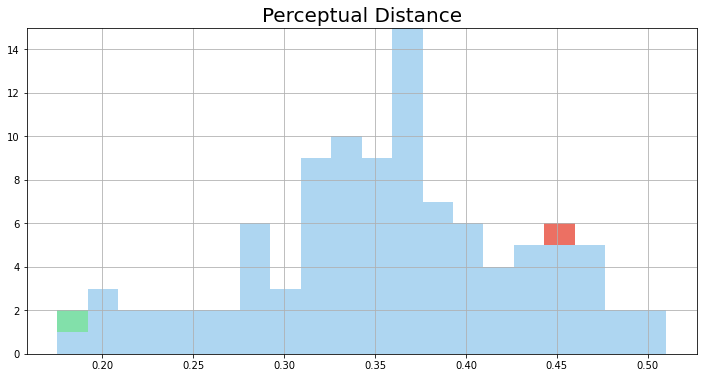

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal[df_normal["Step"]==100]['Perceptual_distance'],df_human[df_human["Step"]==100]['Perceptual_distance'],df_horse[df_horse["Step"]==100]['Perceptual_distance']], bins=20,
             color = ['#AED6F1','#82E0AA','#EC7063'],stacked=True)
plt.title("Perceptual Distance",size=20)
plt.grid()
plt.show()

##### Crop

In [ ]:
%cd /content/usad
!nvcc test_nvcc.cu -o test_nvcc -run

/content/usad
CPU says hello.
GPU says hello.


In [ ]:
import dnnlib.tflib as tflib
from training import misc
from PIL import Image

def crop_images(source):
  targets=[]
  projections=[]
  for i in range(int(len(os.listdir(source))/2)):
    targets.append(np.asarray(Image.open(source+format(i,'04d')+"-target.png").resize((256,256), Image.ANTIALIAS),np.float32))
    projections.append(np.asarray(Image.open(source+format(i,'04d')+"-step0100.png").resize((256,256), Image.ANTIALIAS),np.float32))
  targets=np.asarray(targets)
  projections=np.asarray(projections)
  targets = misc.adjust_dynamic_range(targets, [0, 255], [-1, 1])
  projections = misc.adjust_dynamic_range(projections, [0, 255], [-1, 1])
  targets=targets.transpose([0,3,1,2])
  projections=projections.transpose([0,3,1,2])
  c = int(targets.shape[2] // 8)
  targets = targets[:, :, c*3 : c*7, c*2 : c*6]
  c = int(projections.shape[2] // 8)
  projections = projections[:, :, c*3 : c*7, c*2 : c*6]
  return (targets+ 1) * (255 / 2), (projections+ 1) * (255 / 2)

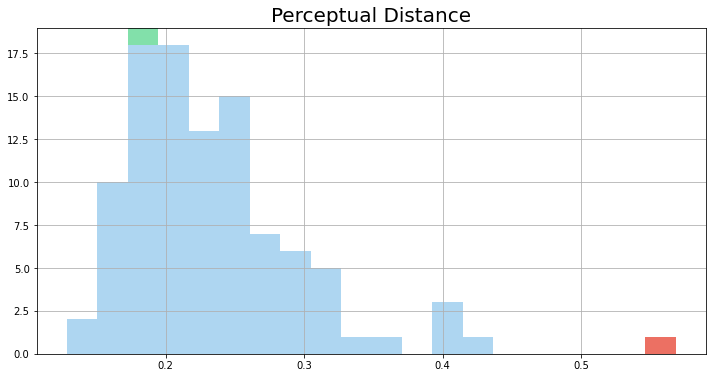

In [ ]:
tflib.init_tf()
distance_measure = misc.load_pkl('http://d36zk2xti64re0.cloudfront.net/stylegan1/networks/metrics/vgg16_zhang_perceptual.pkl')

plt.figure(figsize=(12,6))
plt.hist(tflib.run([
            distance_measure.get_output_for(*crop_images("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_normal/img/")),
            distance_measure.get_output_for(*crop_images("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_human/img/")),
            distance_measure.get_output_for(*crop_images("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_horse/img/"))
           ]),
         bins=20,color = ['#AED6F1','#82E0AA','#EC7063'],stacked=True)
plt.title("Perceptual Distance",size=20)
plt.grid()
plt.show()

#### Euclidean distance

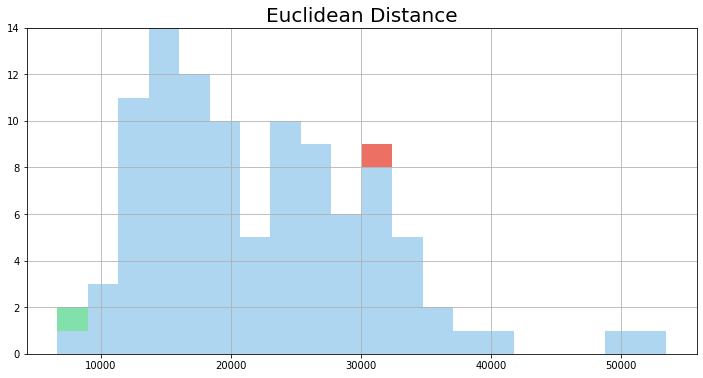

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal[df_normal["Step"]==100]['Euclidean_distance'],df_human[df_human["Step"]==100]['Euclidean_distance'],df_horse[df_horse["Step"]==100]['Euclidean_distance']], bins=20,
             color = ['#AED6F1','#82E0AA','#EC7063'],stacked=True)
plt.title("Euclidean Distance",size=20)
plt.grid()
plt.show()

##### Crop

In [ ]:
%cd /content/usad
!nvcc test_nvcc.cu -o test_nvcc -run

/content/usad
CPU says hello.
GPU says hello.


In [ ]:
import dnnlib.tflib as tflib
from training import misc
from PIL import Image

def crop_images(source):
  targets=[]
  projections=[]
  for i in range(int(len(os.listdir(source))/2)):
    targets.append(np.asarray(Image.open(source+format(i,'04d')+"-target.png").resize((256,256), Image.ANTIALIAS),np.float32))
    projections.append(np.asarray(Image.open(source+format(i,'04d')+"-step0100.png").resize((256,256), Image.ANTIALIAS),np.float32))
  targets=np.asarray(targets)
  projections=np.asarray(projections)
  targets = misc.adjust_dynamic_range(targets, [0, 255], [-1, 1])
  projections = misc.adjust_dynamic_range(projections, [0, 255], [-1, 1])
  targets=targets.transpose([0,3,1,2])
  projections=projections.transpose([0,3,1,2])
  c = int(targets.shape[2] // 8)
  targets = targets[:, :, c*3 : c*7, c*2 : c*6]
  c = int(projections.shape[2] // 8)
  projections = projections[:, :, c*3 : c*7, c*2 : c*6]
  return (targets+ 1) * (255 / 2), (projections+ 1) * (255 / 2)

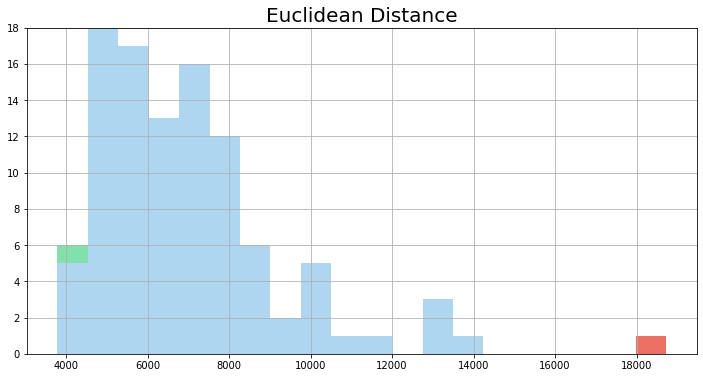

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(tflib.run([[tf.norm(target-projection) for target,projection in zip(*crop_images("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_normal/img/"))],
           [tf.norm(target-projection) for target,projection in zip(*crop_images("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_human/img/"))],
           [tf.norm(target-projection) for target,projection in zip(*crop_images("/content/drive/My Drive/GAN/Week14/FFHQ/1e-1std_5e-3eps_horse/img/"))]
         ]),
         bins=20,color = ['#AED6F1','#82E0AA','#EC7063'],stacked=True)
plt.title("Euclidean Distance",size=20)
plt.grid()
plt.show()

#### APPL

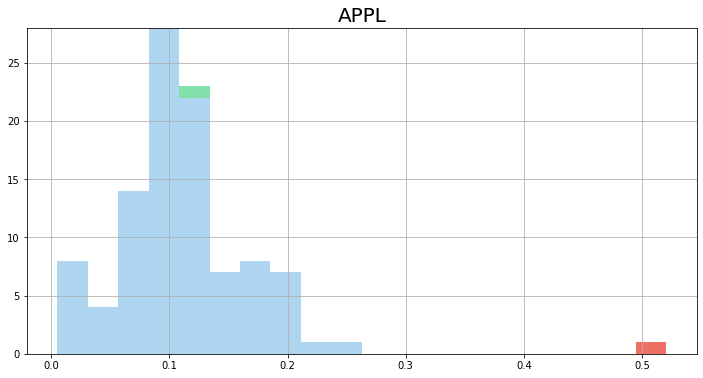

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal[df_normal["Step"]==100]['APPL'],df_human[df_human["Step"]==100]['APPL'],df_horse[df_horse["Step"]==100]['APPL']], bins=20,
             color = ['#AED6F1','#82E0AA','#EC7063'],stacked=True)
plt.title("APPL",size=20)
plt.grid()
plt.show()

### SWaT - encoder

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load_encoder_results(source):
  df=pd.DataFrame()
  n_targets=len(os.listdir(source))

  for target in range(n_targets):
    target=format(target,'04d')
    with open(source+target+'.txt','r') as text:
      data=text.read()
    perc_dist=np.asarray(data.split("Perceptual distance: ")[1].split("\t")[0],dtype="float64")
    eucl_dist=np.asarray(data.split("Euclidean distance: ")[1].split("\t")[0],dtype="float64")
    APPL=np.asarray(data.split("APPL: ")[1].split("\n")[0],dtype="float64")
    df_new=pd.concat([
                  pd.DataFrame([perc_dist],columns =['Perceptual_distance']),
                  pd.DataFrame([eucl_dist],columns =['Euclidean_distance']),
                  pd.DataFrame([APPL],columns =['APPL'])
              ],axis=1)
    df=pd.concat([
                  df,
                  df_new
              ],axis=0,ignore_index=True)

  return df

In [ ]:
df_normal=load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_5e-3eps_normal/text/")
df_normal

,Perceptual_distance,Euclidean_distance,APPL
0,0.323397,154.345180,0.216728
1,0.361489,141.034360,0.161745
2,0.201141,80.161400,0.232054
3,0.257337,95.688080,0.107121
4,0.319611,62.390553,0.092135
...,...,...,...
95,0.295502,91.192270,0.134982
96,0.170064,63.477730,0.034337
97,0.565083,229.669940,0.033910
98,0.416356,159.498290,0.042704


In [ ]:
df_attack=load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_5e-3eps_attack/text/")
df_attack

,Perceptual_distance,Euclidean_distance,APPL
0,0.461356,165.67377,0.244308
1,0.286566,95.40217,0.097548
2,0.446988,160.79590,0.318489
3,0.482396,117.99570,0.059537
4,0.423858,141.35880,0.349999
...,...,...,...
95,0.266143,90.01821,0.084545
96,0.270846,93.10123,0.239372
97,0.203922,94.15290,0.155336
98,0.365955,163.48523,0.196016


#### Perceptual distance

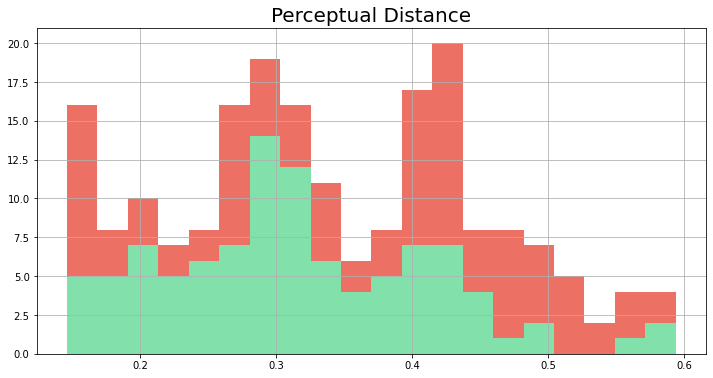

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal['Perceptual_distance'],df_attack['Perceptual_distance']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("Perceptual Distance",size=20)
plt.grid()
plt.show()

#### Euclidean distance

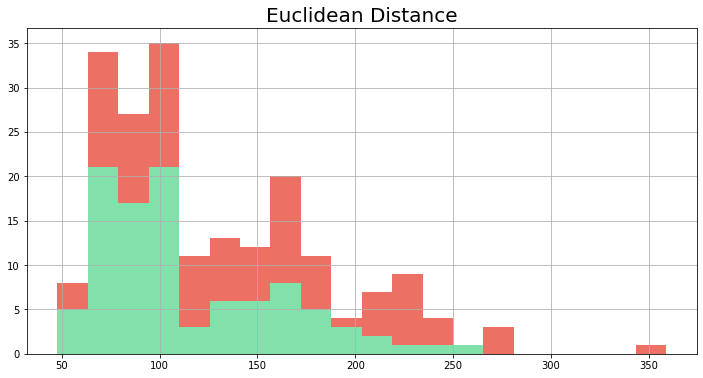

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal['Euclidean_distance'],df_attack['Euclidean_distance']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("Euclidean Distance",size=20)
plt.grid()
plt.show()

#### APPL

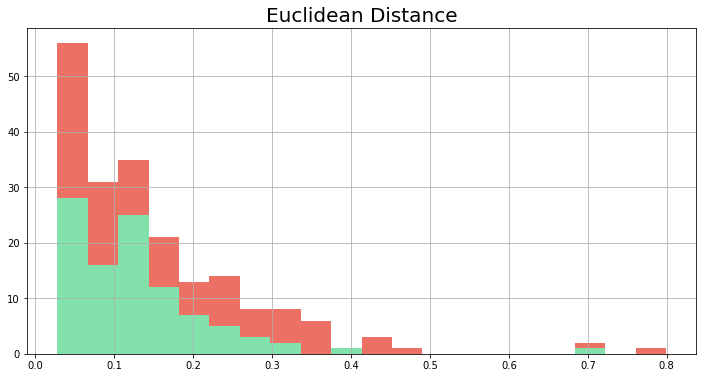

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal['APPL'],df_attack['APPL']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("APPL",size=20)
plt.grid()
plt.show()

##### EPS=1e-4

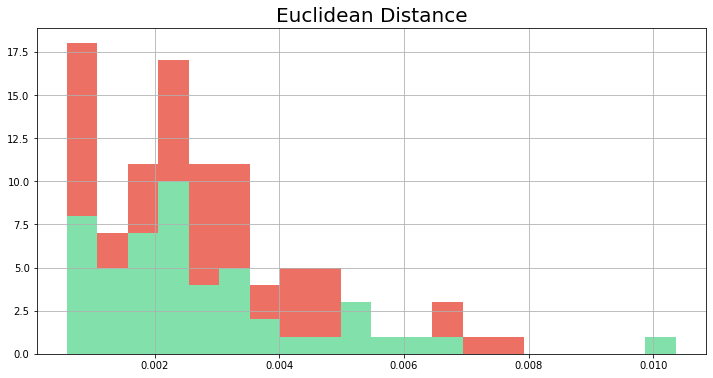

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_1e-4eps_normal/text/")['APPL'],
          load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_1e-4eps_attack/text/")['APPL']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("APPL",size=20)
plt.grid()
plt.show()

##### EPS=1e-1

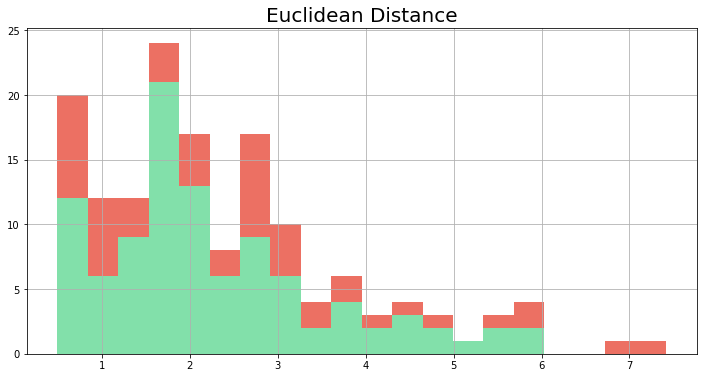

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_1e-1eps_normal/text/")['APPL'],
          load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_1e-1eps_attack/text/")['APPL']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("APPL",size=20)
plt.grid()
plt.show()

##### Face-attack

In [ ]:
df_normal=load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_5e-3eps_normal/text/")
df_attack=load_encoder_results("/content/drive/My Drive/GAN/Week14/SWaT/encoder/1e-1std_5e-3eps_face-attack/text/")

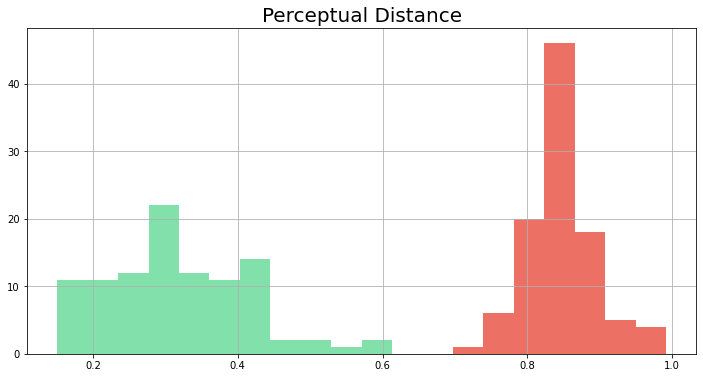

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal['Perceptual_distance'],df_attack['Perceptual_distance']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("Perceptual Distance",size=20)
plt.grid()
plt.show()

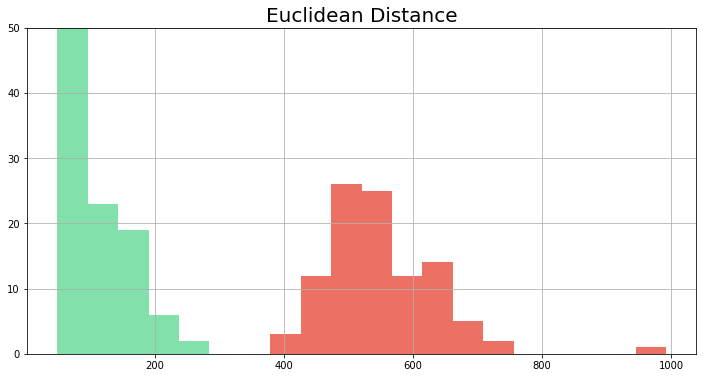

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal['Euclidean_distance'],df_attack['Euclidean_distance']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("Euclidean Distance",size=20)
plt.grid()
plt.show()

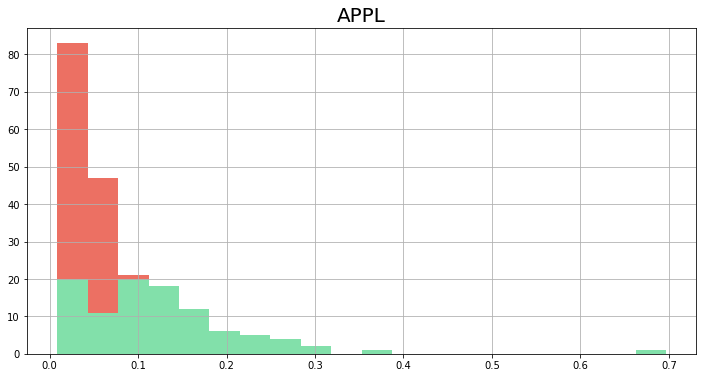

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal['APPL'],df_attack['APPL']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("APPL",size=20)
plt.grid()
plt.show()

### SWat - projection

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_normal=load_projection_results("/content/drive/My Drive/GAN/Week14/SWaT/projection/1e-1std_5e-3eps_normal/text/",n=100)
df_normal

,Target,Step,Perceptual_distance,Euclidean_distance,APPL
0,0000,10,0.275084,12409.00,0.055998
1,0000,20,0.208169,12702.30,0.055998
2,0000,30,0.220577,11394.00,0.055998
3,0000,40,0.175101,10949.70,0.055998
4,0000,50,0.168849,9579.85,0.055998
...,...,...,...,...,...
995,0009,960,0.187436,25037.10,0.046424
996,0009,970,0.187419,25037.80,0.046424
997,0009,980,0.187411,25037.20,0.046424
998,0009,990,0.187408,25036.70,0.046424


In [ ]:
df_attack=load_projection_results("/content/drive/My Drive/GAN/Week14/SWaT/projection/1e-1std_5e-3eps_attack/text/",n=100)
df_attack

,Target,Step,Perceptual_distance,Euclidean_distance,APPL
0,0000,10,0.609391,42760.80,0.070129
1,0000,20,0.606032,44207.30,0.070129
2,0000,30,0.624980,43414.00,0.070129
3,0000,40,0.573743,42580.00,0.070129
4,0000,50,0.569593,41444.30,0.070129
...,...,...,...,...,...
995,0009,960,0.076346,6828.23,0.019447
996,0009,970,0.076340,6828.20,0.019447
997,0009,980,0.076337,6828.20,0.019447
998,0009,990,0.076335,6828.21,0.019447


#### Perceptual distance

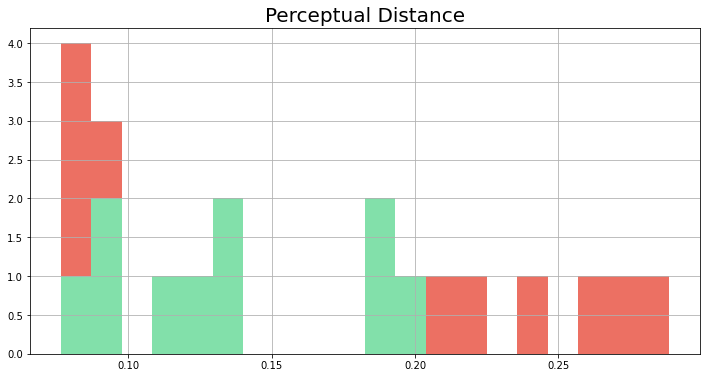

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal[df_normal["Step"]==1000]['Perceptual_distance'],df_attack[df_attack["Step"]==1000]['Perceptual_distance']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("Perceptual Distance",size=20)
plt.grid()
plt.show()

#### Euclidean distance

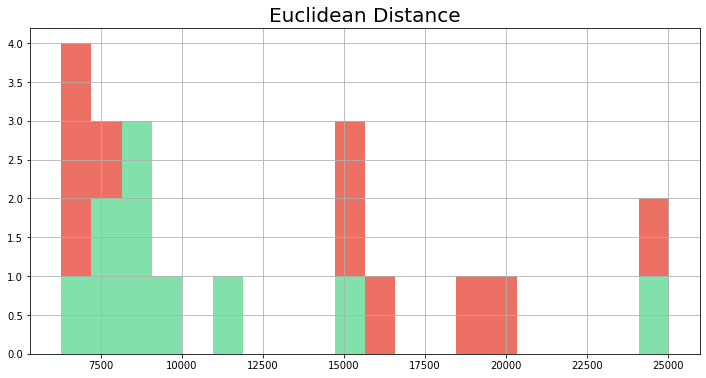

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal[df_normal["Step"]==1000]['Euclidean_distance'],df_attack[df_attack["Step"]==1000]['Euclidean_distance']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("Euclidean Distance",size=20)
plt.grid()
plt.show()

#### APPL

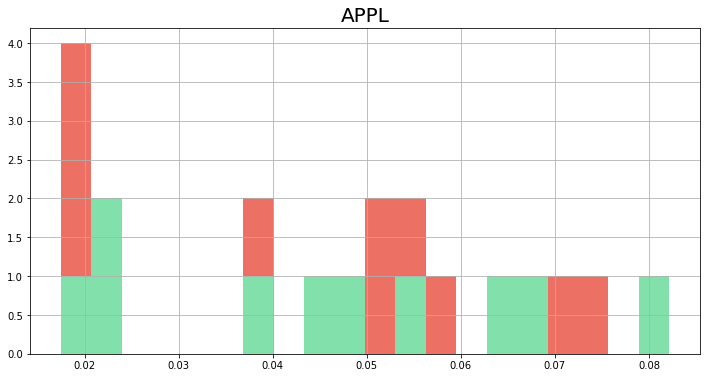

In [ ]:
plt.figure(figsize=(12,6))
plt.hist([df_normal[df_normal["Step"]==1000]['APPL'],df_attack[df_attack["Step"]==1000]['APPL']],
        bins=20,
        color = ['#82E0AA','#EC7063'],stacked=True)
plt.title("APPL",size=20)
plt.grid()
plt.show()